# <b><font color='#009e74'>Rapid protein stability prediction using deep learning representations </font></b>

Preprint pipeline version for predicting protein variants **thermodynamic stability changes** ($\Delta \Delta G$) using a deep learning representation. The program, using as input a protein structure (uploaded as PDB) returns stability predictions ($\Delta \Delta G$ in kcal/mol) for each variant at each position of the query protein.
More details can be found in: **Blaabjerg et al.:** ["Rapid protein stability prediction using deep learning representations"](https://www.biorxiv.org/content/10.1101/2022.07.14.500157v1). Source code is available on the project [Github](https://github.com/KULL-Centre/_2022_ML-ddG-Blaabjerg) page.


##  <b><font color='#009e74'> Reminders and Important informations:</font></b>
- This notebook  <b><font color='#d55c00'>must</font></b> be run in a Colab GPU session (go to page menu: `Runtime`->  `Change runtime type` -> select `GPU` and confirm
- Run <b><font color='#d55c00'>ONE</font></b> cell at a time, <b><font color='#d55c00'>DON'T USE</font></b> the `Runtime`->  `Run all` function as condacolab installation requires a restart of the kernel.
- Cells labelled <b><font color='#56b4e9'>PRELIMINARY OPERATIONS </font></b>  must be run <b><font color='#d55c00'>ONE</font></b> at a time and <b><font color='#d55c00'>ONCE</font></b> at the start and skipped for new predictions.
- Cells named as  <b><font color='#56b4e9'>PRELIMINARY OPERATIONS </font></b> have to be run <b><font color='#d55c00'>ONE BY ONE</font></b>  and <font color='#d55c00'>ONCE only at the start</font></b>  and  skipped for new predictions.
- <b><font color='#d55c00'>ONE</font></b> single pdb at the time can be processed by the pipeline.
- A  <b><font color='#d55c00'>new run</font></b> can be perform input direcly the new structure in the pdb upload cell and run the prediction cell again

****

## <b><font color='#009e74'>PIPELINE : PRELIMINARY OPERATIONS </font></b>
These cells MUST be run <b><font color='#d55c00'>INDIVIDUALLY AND SEQUENTIALLY</font></b>, and only once at the start of the notebook.
****

In [ ]:
#@title <b><font color='#56b4e9'>PRELIMINARY OPERATIONS</font>: Install condacolab
#@markdown Run this cell to install condacolab. After running this cell the kernel will be automatically restarted (wait ~1min before run the next cell)

#@markdown **N.B: This cell should be run only ONCE at the START of the notebook.**
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [ ]:
#@title <b><font color='#56b4e9'>PRELIMINARY OPERATIONS</font>: Setup enviroment and dependencies</b>

#@markdown Run this cell to install the required enviroment and dependencies (~10 minutes)

#@markdown **N.B: This cell should be run only ONCE at the START of the notebook.**
! rm -r sample_data

# install dependencies present in pip
! pip install torch==1.12.0 biopython==1.72 matplotlib pdb-tools &> /dev/null
! pip install --upgrade pdb-tools
! echo "-> packages with pip installed!"

! mamba install  pdbfixer=1.8.1 openmm=8.0 pandas=1.4.4 cudatoolkit=11.8 -c omnia -c conda-forge -c anaconda -c defaults --yes &> /dev/null
! echo "-> packages with conda installed!"
### mpl-scatter-density ptitprince


-> packages with pip installed!
-> packages with conda installed!


In [ ]:
#@title <b><font color='#56b4e9'>PRELIMINARY OPERATIONS</font>: Retrieve parameters and RaSP files</b>

#@markdown Run this cell to import RaSP files and parameters

#@markdown **N.B: This cell should be run only ONCE at the START of the notebook.**
%%bash

#install svn
apt-get install -qq subversion > /dev/null

#mkdir of necessary folders
mkdir data
mkdir data/test
mkdir data/test/predictions
mkdir data/test/predictions/raw
mkdir data/test/predictions/cleaned
mkdir data/test/predictions/parsed
# mkdir data/train/downstream/structure/
mkdir output/
mkdir output/predictions

#download project folders from github

wget -cq https://github.com/KULL-Centre/papers/raw/main/2022/ML-ddG-Blaabjerg-et-al/colab_additonals/extra_colab.zip &> /dev/null
unzip extra_colab.zip &> /dev/null


wget -cq https://github.com/KULL-Centre/papers/raw/papers/2022/ML-ddG-Blaabjerg-et-al/data/pdb_frequencies.npz -o /content/data/pdb_frequencies.npz
wget -cq https://github.com/KULL-Centre/papers/raw/main/2022/ML-ddG-Blaabjerg-et-al/colab_additonals/colab_additional.zip

# #extra files for runnin the notebooks

mv ds_models ./output/
mv cavity_models ./output/

unzip colab_additional.zip &> /dev/null
rm colab_additional.zip

mv /content/colab_additional/best_model_path.txt /content/output/cavity_models/
mv /content/colab_additional/clean_pdb.py /content/src/pdb_parser_scripts/
mv /content/colab_additional/helpers.py /content/src/
mv /content/colab_additional/pdb_frequencies.npz /content/data/

echo "---> Github data imported!"

# #get and compile reduce

cd src/pdb_parser_scripts
git clone https://github.com/rlabduke/reduce.git
cd reduce/
make &> /dev/null

mv /content/colab_additional/reduce /content/src/pdb_parser_scripts/reduce/

chmod +x /content/src/pdb_parser_scripts/reduce/reduce
echo "----> reduce installed"

rm -r /content/colab_additional
# #@markdown ****

---> Github data imported!
----> reduce installed


Cloning into 'reduce'...


In [ ]:
!pip install mpl_scatter_density
!pip install ptitprince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.5/655.5 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 24.4 MB/s eta 0:00:00
  Created wheel for ptitprince: filename=ptitprince-0.2.7-py3-none-any.whl size=10655 sha256=dd9c9c681d90f1592d947a0d9c6963809746513291fa4bb6bcc054136751d2c9
  Stored in directory: /root/.cache/pip/wheels/0e/43/31/e76a3bf61865543f076a9d9eb027a740caefb379424ecba4e8
Successfully built ptitprince


In [ ]:
!wget -cq https://raw.githubusercontent.com/KULL-Centre/_2022_ML-ddG-Blaabjerg/main/data/train/downstream/ddG_Rosetta/ddg.csv -O /content/data/ddg.csv
# !wget -cq https://github.com/KULL-Centre/_2022_ML-ddG-Blaabjerg/tree/main/data/train/downstream/structure/raw

In [ ]:
#@title <b><font color='#56b4e9'>PRELIMINARY OPERATIONS</font>: Import python libraries, functions and setup common variables</b>

#@markdown Run this cell to import libraries and functions necessary for the pipeline.

#@markdown **N.B: This cell should be run only ONCE at the START of the notebook.**

import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")

import glob
import os
import random
import pathlib
import subprocess
import numpy as np
import pandas as pd
import torch
import time
import datetime
import matplotlib
from pdbfixer import PDBFixer
from openmm.app import PDBFile
from Bio.PDB.Polypeptide import index_to_one, one_to_index
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset
from google.colab import files

sys.path.append('/content/src/')

from cavity_model import (
     CavityModel,
     DownstreamModel,
     ResidueEnvironment,
     ResidueEnvironmentsDataset,
)

from helpers import (
     populate_dfs_with_resenvs,
     remove_disulfides,
     fermi_transform,
     inverse_fermi_transform,
     init_lin_weights,
     ds_train_val,
     ds_pred,
     train_val_split_ds,
     cavity_to_prism,
     get_seq_from_variant,
)

#from visualization import (
#     hist_plot,
#)

#Extra function to fix pdb

# Setup pipeline parameters
## Set seeds
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Main deep parameters
DEVICE = "cuda"  # "cpu" or "cuda"
NUM_ENSEMBLE = 10
TASK_ID = int(1)
PER_TASK = int(1)

#@markdown ****

## <b><font color='#009e74'>PIPELINE : PREDICTIONS </font></b>

In [ ]:
#@title <b><font color='#56b4e9'> PDB upload</font></b>

#@markdown Choose between <b><font color='#d55c00'> ONE</font></b> of the possible input sources for the target pdb and <b><font color='#d55c00'>leave the other cells empty or unmarked</font></b>
#@markdown - AlphaFold2 PDB (v4) via Uniprot ID:
AF_ID ='P68871'#@param {type:"string"}
#@markdown - PDB ID (imported from RCSB PDB):
PDB_ID =''#@param {type:"string"}
#@markdown - Upload custom PDB
PDB_custom =False#@param {type:"boolean"}

#@markdown

#@markdown Select target chain (default A)
chain='A' #@param {type:'string'}

if os.path.exists("/content/query_protein.pdb"):
    os.remove("/content/query_protein.pdb")
if os.path.exists("/content/data/test/predictions/raw/query_protein_uniquechain.pdb"):
    os.remove("/content/data/test/predictions/raw/query_protein_uniquechain.pdb")
if os.path.exists("/content/data/test/predictions/cleaned/query_protein_uniquechain_clean.pdb"):
    os.remove("/content/data/test/predictions/cleaned/query_protein_uniquechain_clean.pdb")
if os.path.exists("/content/data/test/predictions/parsed/query_protein_uniquechain_clean_coordinate_features.npz"):
    os.remove("/content/data/test/predictions/parsed/query_protein_uniquechain_clean_coordinate_features.npz")

if PDB_custom:
  print('Upload PDB file:')
  uploaded_pdb = files.upload()
  for fn in uploaded_pdb.keys():
    os.rename(fn, f"/content/query_protein.pdb")
    print('PDB file correctly loaded')
elif (AF_ID !='') and (len(AF_ID)>=6) :
    subprocess.call(['curl','-s','-f',f'https://alphafold.ebi.ac.uk/files/AF-{AF_ID}-F1-model_v4.pdb','-o','/content/query_protein.pdb'])
elif (PDB_ID !='') and (len(PDB_ID)==4):
    subprocess.call(['curl','-s','-f',f'https://files.rcsb.org/download/{PDB_ID}.pdb','-o','/content/query_protein.pdb'])

else:
  print(f'ERROR: any PDB uploaded, please select one of the above inputs')

#@markdown N.B. This cell will also perform preliminary operations to correcly format the uploaded PDB

## remove other chains and move to raw folder
!pdb_selchain -"$chain" /content/query_protein.pdb | pdb_delhetatm | pdb_delres --999:0:1 | pdb_fixinsert | pdb_tidy  > /content/data/test/predictions/raw/query_protein_uniquechain.pdb
# Select PDBs to run during this task - could be simplified if we decide to set PER_TASK = 1 for all cases

pdb_input_dir = "data/test/predictions/raw/"
input_pdbs = sorted(list(filter(lambda x: x.endswith(".pdb"), os.listdir('data/test/predictions/raw/'))))
start = (TASK_ID-1)*(PER_TASK)
end = (TASK_ID*PER_TASK)
if end > len(input_pdbs):
    end = len(input_pdbs) #avoid end index exceeding length of list
pdbs = input_pdbs[start:end]
pdb_names = [i.split(".")[0] for i in pdbs]
print(pdb_names)
print(f"Pre-processing PDBs ...")

!python3 /content/src/pdb_parser_scripts/clean_pdb.py --pdb_file_in /content/data/test/predictions/raw/query_protein_uniquechain.pdb --out_dir /content/data/test/predictions/cleaned/ --reduce_exe /content/src/pdb_parser_scripts/reduce/reduce #&> /dev/null
!python3 /content/src/pdb_parser_scripts/extract_environments.py --pdb_in /content/data/test/predictions/cleaned/query_protein_uniquechain_clean.pdb  --out_dir /content/data/test/predictions/parsed/  #&> /dev/null

if os.path.exists("/content/data/test/predictions/parsed/query_protein_uniquechain_clean_coordinate_features.npz"):
  print(f"Pre-processing PDBs correctly ended")
else:
  print(f"Pre-processing PDB didn't end correcly, please check input informations")

#@markdown ****

['query_protein_uniquechain']
Pre-processing PDBs ...
Time for cleaning /content/data/test/predictions/raw/query_protein_uniquechain.pdb: 4.313004970550537
/usr/local/lib/python3.10/site-packages/Bio/PDB/Vector.py:38: BiopythonDeprecationWarning: The module Bio.PDB.Vector has been deprecated in favor of new module Bio.PDB.vectors to solve a name collision with the class Vector. For the class Vector, and vector functions like calc_angle, import from Bio.PDB instead.
  warnings.warn("The module Bio.PDB.Vector has been deprecated in "
Time for parsing environments from /content/data/test/predictions/cleaned/query_protein_uniquechain_clean.pdb: 0.19596123695373535
Pre-processing PDBs correctly ended


In [ ]:
#@title <b><font color='#56b4e9'> func </font></b>
import datetime
import itertools
import os
import pickle
import random
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import torch
from Bio.PDB.Polypeptide import index_to_one, one_to_index
from scipy.stats import pearsonr
from sklearn.utils import resample
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

# from rasp_model import (
#     CavityModel,
#     DDGDataset,
#     DDGToTensor,
#     DownstreamModel,
#     ResidueEnvironmentsDataset,
#     ToTensor,
# )
from PrismData import PrismParser, VariantData
from visualization import learning_curve_cavity, learning_curve_ds


def ds_train_val(
    df_ddg,
    dataloader_train,
    dataloader_val,
    cavity_model_net,
    ds_model_net,
    loss_func,
    optimizer,
    model_idx,
    EPOCHS,
    DEVICE,
):
    """
    Trains the downstream model in a loop over EPOCHS.
    """

    # Set seed
    np.random.seed(model_idx)
    random.seed(model_idx)
    torch.manual_seed(model_idx)
    torch.cuda.manual_seed(model_idx)
    torch.cuda.manual_seed_all(model_idx)

    # Initialize
    train_loss_list = []
    val_loss_list = []
    pearson_r_list = []

    for epoch in range(EPOCHS):

        print(f"Epoch: {epoch+1}/{EPOCHS}")

        # Initialize
        train_loss_batch_list = torch.empty(0, dtype=torch.float32).to(DEVICE)
        val_loss_batch_list = torch.empty(0, dtype=torch.float32).to(DEVICE)
        val_ddg_fermi = torch.empty(0, dtype=torch.float32).to(DEVICE)
        val_ddg_fermi_pred = torch.empty(0, dtype=torch.float32).to(DEVICE)
        val_ddg = torch.empty(0, dtype=torch.float32).to(DEVICE)

        # Train loop
        ds_model_net.train()

        for _, _, _, x_cavity_batch, x_ds_batch, ddg_fermi_batch, _ in dataloader_train:

            # Initialize optimizer
            optimizer.zero_grad()

            # Compute predictions
            cavity_pred_batch = cavity_model_net(x_cavity_batch)
            ddg_fermi_batch_pred = ds_model_net(
                torch.cat((cavity_pred_batch, x_ds_batch), 1)
            )
            loss_batch = loss_func(ddg_fermi_batch_pred, ddg_fermi_batch)
            loss_batch.backward()
            optimizer.step()

            # Append to epoch
            train_loss_batch_list = torch.cat(
                (train_loss_batch_list, loss_batch.detach().reshape(-1))
            )

        # Val loop
        ds_model_net.eval()
        with torch.no_grad():

            for (
                _,
                _,
                _,
                val_x_cavity_batch,
                val_x_ds_batch,
                val_ddg_fermi_batch,
                val_ddg_batch,
            ) in dataloader_val:

                # Compute predictions
                val_cavity_pred_batch = cavity_model_net(val_x_cavity_batch)
                val_ddg_fermi_pred_batch = ds_model_net(
                    torch.cat((val_cavity_pred_batch, val_x_ds_batch), 1)
                )
                val_loss_batch = loss_func(
                    val_ddg_fermi_pred_batch, val_ddg_fermi_batch
                )

                # Append to epoch
                val_loss_batch_list = torch.cat(
                    (val_loss_batch_list, val_loss_batch.reshape(-1))
                )
                val_ddg_fermi = torch.cat(
                    (val_ddg_fermi, val_ddg_fermi_batch.reshape(-1)), 0
                )
                val_ddg_fermi_pred = torch.cat(
                    (val_ddg_fermi_pred, val_ddg_fermi_pred_batch.reshape(-1)), 0
                )
                val_ddg = torch.cat((val_ddg, val_ddg_batch.reshape(-1)), 0)

        # Compute epoch metrics
        train_loss_list.append(train_loss_batch_list.mean().cpu().item())
        val_loss_list.append(val_loss_batch_list.mean().cpu().item())
        val_ddg = val_ddg.detach().cpu()
        val_ddg_fermi_pred = val_ddg_fermi_pred.detach().cpu()
        val_ddg_pred = val_ddg_fermi_pred.apply_(lambda x: inverse_fermi_transform(x))
        # print(len(val_ddg))
        # print(len(val_ddg_pred))
        # print(len(train_loss_list))
        # print(len(val_loss_list))

        # print(val_loss_list)
        # print(train_loss_list)
        pearson_r_list.append(pearsonr(val_ddg_pred.numpy(), val_ddg.numpy())[0])

    # Print learning curve
    try:
      learning_curve_ds(pearson_r_list, val_loss_list, train_loss_list, model_idx)
    except:
      pass

    # Save results and model
    lc_results = (pearson_r_list, val_loss_list, train_loss_list, model_idx)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label="Training Loss")
    plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
    # with open(
    #     f"{os.path.dirname(sys.path[0])}/output/ds_models/ds_model_{model_idx}/lc_results.pkl",
    #     "wb",
    # ) as f:
    #     pickle.dump(lc_results, f)
    # torch.save(
    #     ds_model_net.state_dict(),
    #     f"{os.path.dirname(sys.path[0])}/output/ds_models/ds_model_{model_idx}/model.pt",
    # )


In [ ]:
def populate_dfs_wth_resenvs(ddg_data, resenv_dataset):
    """
    Populates ddG dfs with the wt ResidueEnvironment objects.
    """
    print(
        "Dropping data points where residue is not defined in structure "
        f"or due to missing parsed pdb file"
    )
    # Add wt residue environments to standard ddg data dataframes

    resenvs_ddg_data = []
    for idx, row in ddg_data.iterrows():
        resenv_key = (
            f"{row['pdbid']}{row['chainid']}_"
            f"{row['variant'][1:-1]}{row['variant'][0]}"
        )
        try:
            resenv = resenv_dataset[resenv_key]
            resenvs_ddg_data.append(resenv)
        except KeyError:
            print(resenv_key + " " "Could not be found in structure data")
            resenvs_ddg_data.append(np.nan)
    ddg_data["resenv"] = resenvs_ddg_data
    n_datapoints_before = ddg_data.shape[0]
    ddg_data.dropna(inplace=True)
    n_datapoints_after = ddg_data.shape[0]
    print(
        f"dropped {n_datapoints_before - n_datapoints_after:4d} / "
        f"{n_datapoints_before:4d} data points from dataset."
    )

    # Load PDB amino acid frequencies used to approximate unfolded states
    pdb_nlfs = -np.log(
        np.load(
            "/content/data/pdb_frequencies.npz"
        )["frequencies"]
    )

    # Add wt and mt idxs and freqs to df
    ddg_data["wt_idx"] = ddg_data.apply(
        lambda row: one_to_index(row["variant"][0]), axis=1
    )
    ddg_data["mt_idx"] = ddg_data.apply(
        lambda row: one_to_index(row["variant"][-1]), axis=1
    )
    ddg_data["wt_nlf"] = ddg_data.apply(lambda row: pdb_nlfs[row["wt_idx"]], axis=1)
    ddg_data["mt_nlf"] = ddg_data.apply(lambda row: pdb_nlfs[row["mt_idx"]], axis=1)

In [ ]:

#@title <b><font color='#56b4e9'> Pipeline RUN </font></b>

#@markdown <b><font color='#d55c00'>Execute the cell</font></b> to run the pipeline and generate **saturation mutagenesis predictions of thermodynamic stability changes** predictions

### Pre-process structure data

# Create temporary residue environment datasets to more easily match ddG data
pdb_filenames_ds = sorted(glob.glob(f"/content/data/test/predictions/parsed/*coord*"))

dataset_structure = ResidueEnvironmentsDataset(pdb_filenames_ds, transformer=None)

resenv_dataset = {}
for resenv in dataset_structure:
    if AF_ID!='':
      key = (f"--{AF_ID}--{resenv.chain_id}--{resenv.pdb_residue_number}--{index_to_one(resenv.restype_index)}--"
          )
    elif PDB_ID!='':
      key = (f"--{PDB_ID}--{resenv.chain_id}--{resenv.pdb_residue_nzumber}--{index_to_one(resenv.restype_index)}--"
          )
    else:
      key = (f"--{'CUSTOM'}--{resenv.chain_id}--{resenv.pdb_residue_number}--{index_to_one(resenv.restype_index)}--"
          )
    resenv_dataset[key] = resenv
df_structure_no_mt = pd.DataFrame.from_dict(resenv_dataset, orient='index', columns=["resenv"])
df_structure_no_mt.reset_index(inplace=True)
df_structure_no_mt["index"]=df_structure_no_mt["index"].astype(str)
res_info = pd.DataFrame(df_structure_no_mt["index"].str.split('--').tolist(),
                        columns = ['blank','pdb_id','chain_id','pos','wt_AA', 'blank2'])

df_structure_no_mt["pdbid"] = res_info['pdb_id']
df_structure_no_mt["chainid"] = res_info['chain_id']
df_structure_no_mt["variant"] = res_info["wt_AA"] + res_info['pos'] + "X"
aa_list = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L",
            "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
df_structure = pd.DataFrame(df_structure_no_mt.values.repeat(20, axis=0), columns=df_structure_no_mt.columns)
for i in range(0, len(df_structure), 20):
    for j in range(20):
        df_structure.iloc[i+j, :]["variant"] = df_structure.iloc[i+j, :]["variant"][:-1] + aa_list[j]
df_structure.drop(columns="index", inplace=True)

# Load PDB amino acid frequencies used to approximate unfolded states
pdb_nlfs = -np.log(np.load(f"{os.getcwd()}/data/pdb_frequencies.npz")["frequencies"])

# # Add wt and mt idxs and freqs to df d
df_structure["wt_idx"] = df_structure.apply(lambda row: one_to_index(row["variant"][0]), axis=1)
df_structure["mt_idx"] = df_structure.apply(lambda row: one_to_index(row["variant"][-1]), axis=1)
df_structure["wt_nlf"] = df_structure.apply(lambda row: pdb_nlfs[row["wt_idx"]], axis=1)
df_structure["mt_nlf"] = df_structure.apply(lambda row: pdb_nlfs[row["mt_idx"]], axis=1)

# Define models
best_cavity_model_path = open(f"/content/output/cavity_models/best_model_path.txt", "r").read()
cavity_model_net = CavityModel(get_latent=True).to(DEVICE)
cavity_model_net.load_state_dict(torch.load(f"{best_cavity_model_path}"))
cavity_model_net.eval()
ds_model_net = DownstreamModel().to(DEVICE)
ds_model_net.apply(init_lin_weights)
# ds_model_net.load_state_dict(torch.load("/content/output/ds_models/ds_model_0/model.pt"))  # Load the weights
ds_model_net.eval()

###set start time
start_time = time.perf_counter()

# Make ML predictions
print(f"Starting downstream model prediction")
dataset_key="predictions"
df_ml = ds_pred(
                cavity_model_net,
                ds_model_net,
                df_structure,
                dataset_key,
                NUM_ENSEMBLE,
                DEVICE,
                )
print(f"Finished downstream model prediction")
end_time = time.perf_counter()
elapsed = datetime.timedelta(seconds = end_time - start_time)
print("Complete - prediction execution took", elapsed)

elapsed = datetime.timedelta(seconds = end_time - start_time)
print("Generating output files")
#Merge and save data with predictions

df_total = df_structure.merge(df_ml, on=['pdbid','chainid','variant'], how='outer')
#df_total["b_factors"] = df_total.apply(lambda row: row["resenv"].b_factors, axis=1)
df_total = df_total.drop("resenv", 1)
print(f"{len(df_structure)-len(df_ml)} data points dropped when matching total data with ml predictions in: {dataset_key}.")

# Parse output into separate files by pdb, print to PRISM format
for pdbid in df_total["pdbid"].unique():
    df_pdb = df_total[df_total["pdbid"]==pdbid]
    for chainid in df_pdb["chainid"].unique():
        pred_outfile = f"{os.getcwd()}/output/{dataset_key}/cavity_pred_{pdbid}_{chainid}.csv"
        print(f"Parsing predictions from pdb: {pdbid}{chainid} into {pred_outfile}")
        df_chain = df_pdb[df_pdb["chainid"]==chainid]
        df_chain = df_chain.assign(pos = df_chain["variant"].str[1:-1])
        df_chain['pos'] = pd.to_numeric(df_chain['pos'])
        first_res_no = min(df_chain["pos"])
        df_chain = df_chain.assign(wt_AA = df_chain["variant"].str[0])
        df_chain = df_chain.assign(mt_AA = df_chain["variant"].str[-1])
        seq = get_seq_from_variant(df_chain)
        df_chain.to_csv(pred_outfile, index=False)
        prism_outfile = f"/content/output/{dataset_key}/prism_cavity_{pdbid}_{chainid}.txt"

        # if (AF_ID !=''):
        #   prism_outfile = f"/content/output/{dataset_key}/prism_cavity_{AF_ID}_{chainid}.txt"
        # elif (PDB_ID !=''):
        #   prism_outfile = f"/content/output/{dataset_key}/prism_cavity_{PDB_ID}_{chainid}.txt"
        # elif PDB_custom:
        #   prism_outfile = f"/content/output/{dataset_key}/prism_cavity_XXXX_{chainid}.txt"
        cavity_to_prism(df_chain, pdbid, chainid, seq, prism_outfile)

# End timer and print result
#!rm /content/output/predictions/*xxxx*.csv
elapsed = datetime.timedelta(seconds = end_time - start_time)
print("Complete - files generated")

#@markdown ****

/content/src/cavity_model.py:259: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  self.xx, self.yy, self.zz = torch.tensor(


Starting downstream model prediction
Finished downstream model prediction
Complete - prediction execution took 0:01:25.996347
Generating output files
0 data points dropped when matching total data with ml predictions in: predictions.
Parsing predictions from pdb: P68871A into /content/output/predictions/cavity_pred_P68871_A.csv
Complete - files generated


<ipython-input-9-1c293baa0d00>:85: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_total = df_total.drop("resenv", 1)
/content/src/PrismData.py:908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe['variant'] = new_var_list
/content/src/PrismData.py:911: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe['n_mut'] = [len(var) for var in var_split]
/content/src/PrismData.py:912: SettingWithCopyWarnin

In [ ]:
# Constraints
# model_idx = 1
NUM_ENSEMBLE = 3
BATCH_SIZE_DS = 40
LEARNING_RATE_DS = 5e-4
EPOCHS_DS = 20
optimizer_ds = torch.optim.Adam(ds_model_net.parameters(), lr=LEARNING_RATE_DS)
loss_ds = torch.nn.L1Loss()


In [ ]:
df_ddg = pd.read_csv("/content/data/ddg.csv")
# populate_dfs_with_resenvs(df_ddg,resenv_dataset)
# populate_dfs_with_resenvs()

# populate remove disulfies and fermi score

df_ddg.head()

,pdbid,chainid,variant,score
0,1P1X,A,M1A,1.071034
1,1P1X,A,M1C,1.210345
2,1P1X,A,M1D,1.135517
3,1P1X,A,M1E,1.291724
4,1P1X,A,M1F,1.673448


In [ ]:
tmp_ddg = df_ddg[:4750] # df_ddg[139330:142308]
tmp_ddg1 = df_ddg[139330:142308]

In [ ]:
tmp_ddg = pd.concat([tmp_ddg,tmp_ddg1])

In [ ]:
len(tmp_ddg)

7728

In [ ]:
# !python3 /content/src/pdb_parser_scripts/clean_pdb.py --pdb_file_in /content/data/test/predictions/raw/query_protein_uniquechain.pdb --out_dir /content/data/test/predictions/cleaned/ --reduce_exe /content/src/pdb_parser_scripts/reduce/reduce #&> /dev/null
# !python3 /content/src/pdb_parser_scripts/extract_environments.py --pdb_in /content/data/test/predictions/cleaned/query_protein_uniquechain_clean.pdb  --out_dir /content/data/test/predictions/parsed/  #&> /dev/null

!python3 /content/src/pdb_parser_scripts/clean_pdb.py --pdb_file_in /content/1P1X.pdb --out_dir /content/output/ --reduce_exe /content/src/pdb_parser_scripts/reduce/reduce #&> /dev/null
!python3 /content/src/pdb_parser_scripts/extract_environments.py --pdb_in /content/output/1P1X_clean.pdb  --out_dir /content/data/  #&> /dev/null

!python3 /content/src/pdb_parser_scripts/clean_pdb.py --pdb_file_in /content/2GRN.pdb --out_dir /content/output/ --reduce_exe /content/src/pdb_parser_scripts/reduce/reduce #&> /dev/null
!python3 /content/src/pdb_parser_scripts/extract_environments.py --pdb_in /content/output/2GRN_clean.pdb  --out_dir /content/data/  #&> /dev/null

Time for cleaning /content/1P1X.pdb: 6.042541742324829
/usr/local/lib/python3.10/site-packages/Bio/PDB/Vector.py:38: BiopythonDeprecationWarning: The module Bio.PDB.Vector has been deprecated in favor of new module Bio.PDB.vectors to solve a name collision with the class Vector. For the class Vector, and vector functions like calc_angle, import from Bio.PDB instead.
  warnings.warn("The module Bio.PDB.Vector has been deprecated in "
Time for parsing environments from /content/output/1P1X_clean.pdb: 0.39480090141296387
Time for cleaning /content/2GRN.pdb: 4.920692205429077
/usr/local/lib/python3.10/site-packages/Bio/PDB/Vector.py:38: BiopythonDeprecationWarning: The module Bio.PDB.Vector has been deprecated in favor of new module Bio.PDB.vectors to solve a name collision with the class Vector. For the class Vector, and vector functions like calc_angle, import from Bio.PDB instead.
  warnings.warn("The module Bio.PDB.Vector has been deprecated in "
Time for parsing environments from /con

In [ ]:
pdb_fname1 = sorted(glob.glob("/content/data/2GRN_clean_coordinate_features.npz"))
pdb_fname1

['/content/data/2GRN_clean_coordinate_features.npz']

In [ ]:
pdb_fname = sorted(glob.glob("/content/data/1P1X_clean_coordinate_features.npz"))
pdb_fname

['/content/data/1P1X_clean_coordinate_features.npz']

In [ ]:
dataset = ResidueEnvironmentsDataset(pdb_fname, transformer=None)

In [ ]:
dataset1 = ResidueEnvironmentsDataset(pdb_fname1, transformer=None)

In [ ]:
d_resenv = {}

for resenv in dataset:
  key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
  d_resenv[key] = resenv

for resenv in dataset1:
  key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
  d_resenv[key] = resenv


In [ ]:
d_resenv

{'1P1XA_1M': <ResidueEnvironment with 69 atoms. pdb_id: 1P1X, chain_id: A, pdb_residue_number: 1, restype_index: 10>,
 '1P1XA_2T': <ResidueEnvironment with 101 atoms. pdb_id: 1P1X, chain_id: A, pdb_residue_number: 2, restype_index: 16>,
 '1P1XA_3D': <ResidueEnvironment with 122 atoms. pdb_id: 1P1X, chain_id: A, pdb_residue_number: 3, restype_index: 2>,
 '1P1XA_4L': <ResidueEnvironment with 173 atoms. pdb_id: 1P1X, chain_id: A, pdb_residue_number: 4, restype_index: 9>,
 '1P1XA_5K': <ResidueEnvironment with 191 atoms. pdb_id: 1P1X, chain_id: A, pdb_residue_number: 5, restype_index: 8>,
 '1P1XA_6A': <ResidueEnvironment with 182 atoms. pdb_id: 1P1X, chain_id: A, pdb_residue_number: 6, restype_index: 0>,
 '1P1XA_7S': <ResidueEnvironment with 238 atoms. pdb_id: 1P1X, chain_id: A, pdb_residue_number: 7, restype_index: 15>,
 '1P1XA_8S': <ResidueEnvironment with 293 atoms. pdb_id: 1P1X, chain_id: A, pdb_residue_number: 8, restype_index: 15>,
 '1P1XA_9L': <ResidueEnvironment with 239 atoms. pdb_

In [ ]:
populate_dfs_wth_resenvs(tmp_ddg,d_resenv)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped    0 / 7728 data points from dataset.


In [ ]:
remove_disulfides(tmp_ddg)

,pdbid,chainid,variant,score,resenv,wt_idx,mt_idx,wt_nlf,mt_nlf
0,1P1X,A,M1A,1.071034,<ResidueEnvironment with 69 atoms. pdb_id: 1P1...,10,0,3.785957,2.483982
1,1P1X,A,M1C,1.210345,<ResidueEnvironment with 69 atoms. pdb_id: 1P1...,10,1,3.785957,4.335140
2,1P1X,A,M1D,1.135517,<ResidueEnvironment with 69 atoms. pdb_id: 1P1...,10,2,3.785957,2.824680
3,1P1X,A,M1E,1.291724,<ResidueEnvironment with 69 atoms. pdb_id: 1P1...,10,3,3.785957,2.712832
4,1P1X,A,M1F,1.673448,<ResidueEnvironment with 69 atoms. pdb_id: 1P1...,10,4,3.785957,3.207937
...,...,...,...,...,...,...,...,...,...
142303,2GRN,A,P157R,-1.146437,<ResidueEnvironment with 86 atoms. pdb_id: 2GR...,12,14,3.080555,3.035567
142304,2GRN,A,P157S,-1.423103,<ResidueEnvironment with 86 atoms. pdb_id: 2GR...,12,15,3.080555,2.844502
142305,2GRN,A,P157T,-0.984828,<ResidueEnvironment with 86 atoms. pdb_id: 2GR...,12,16,3.080555,2.896883
142306,2GRN,A,P157V,-1.101609,<ResidueEnvironment with 86 atoms. pdb_id: 2GR...,12,17,3.080555,2.623741


In [ ]:
tmp_ddg["score_fermi"] = tmp_ddg["score"].apply(fermi_transform)

In [ ]:
# ddg = {}

# for i in range(len(df_ddg)):
#   # print(df_ddg.iloc[i])

#   pdb_id = df_ddg.iloc[i]["pdbid"]
#   varr = df_ddg.iloc[i]["variant"]
#   chaid = df_ddg.iloc[i]["chainid"]
#   sc = df_ddg.iloc[i]["score"]

#   print(pdb_id,varr,chaid,sc)

#   # ddg[pdb_id][varr][chaid] = sc
#     # Check if pdb_id exists in ddg, if not, create a new nested dictionary
#   if pdb_id not in ddg:
#     ddg[pdb_id] = {}
#   # Check if varr exists in ddg[pdb_id], if not, create a new nested dictionary
#   if varr not in ddg[pdb_id]:
#     ddg[pdb_id][varr] = {}

#   ddg[pdb_id][varr][chaid] = sc

#   # if i > 1:
#   #   break

Streaming output truncated to the last 5000 lines.
1OG2 I459V A 0.2296551724138508
1OG2 I459W A 0.9006896551724414
1OG2 I459Y A 1.5036781609196308
1OG2 P460A A 0.5413793103448841
1OG2 P460C A 0.9703448275863124
1OG2 P460D A 0.2858620689655787
1OG2 P460E A 0.2831034482759888
1OG2 P460F A -1.1265517241378709
1OG2 P460G A 1.6013793103449083
1OG2 P460H A 0.2859770114943378
1OG2 P460I A -0.07091954022975
1OG2 P460K A 0.8791954022988899
1OG2 P460L A 0.2144827586207924
1OG2 P460M A 0.4090804597701898
1OG2 P460N A 0.5110344827586106
1OG2 P460Q A 0.9608045977013496
1OG2 P460R A 0.8600000000000491
1OG2 P460S A 0.8093103448276577
1OG2 P460T A 0.6579310344828816
1OG2 P460V A -0.1437931034482469
1OG2 P460W A -1.4063218390804744
1OG2 P460Y A -1.2003448275861266
1OG2 V461A A 0.6899999999999135
1OG2 V461C A 0.6668965517240489
1OG2 V461D A 0.9296551724137628
1OG2 V461E A 1.8606896551723209
1OG2 V461F A 2.0154022988504825
1OG2 V461G A 0.9255172413792212
1OG2 V461H A 0.8291954022988962
1OG2 V461I A 0.475

In [ ]:
# for i in range(len(df_structure)):
#   pdb_id = df_structure.iloc[i]["pdbid"]
#   varr = df_structure.iloc[i]["variant"]
#   chaid = df_structure.iloc[i]["chainid"]

# df_structure["score"] = 1

# df_structure["score_fermi"] = df_structure["score"].apply(fermi_transform)

In [ ]:
dataloader_train_ds, dataloader_val_ds = train_val_split_ds(
        tmp_ddg, BATCH_SIZE_DS, DEVICE
    )

Training data set includes 1 pdbs with 4750 mutations.
Training PDBs are: ['1P1X'].
Validation data set includes 10 pdbs with 2978 mutations.
Validation PDBs are: ['2GRN' '3UFJ' '6R5K' '6B0N' '4QO1' '1BRW' '2OCP' '1DO6' '1ZG4' '1ARZ'].


Training model: 1/3
Epoch: 1/20
Epoch: 2/20
Epoch: 3/20
Epoch: 4/20
Epoch: 5/20
Epoch: 6/20
Epoch: 7/20
Epoch: 8/20
Epoch: 9/20
Epoch: 10/20
Epoch: 11/20
Epoch: 12/20
Epoch: 13/20
Epoch: 14/20
Epoch: 15/20
Epoch: 16/20
Epoch: 17/20
Epoch: 18/20
Epoch: 19/20
Epoch: 20/20


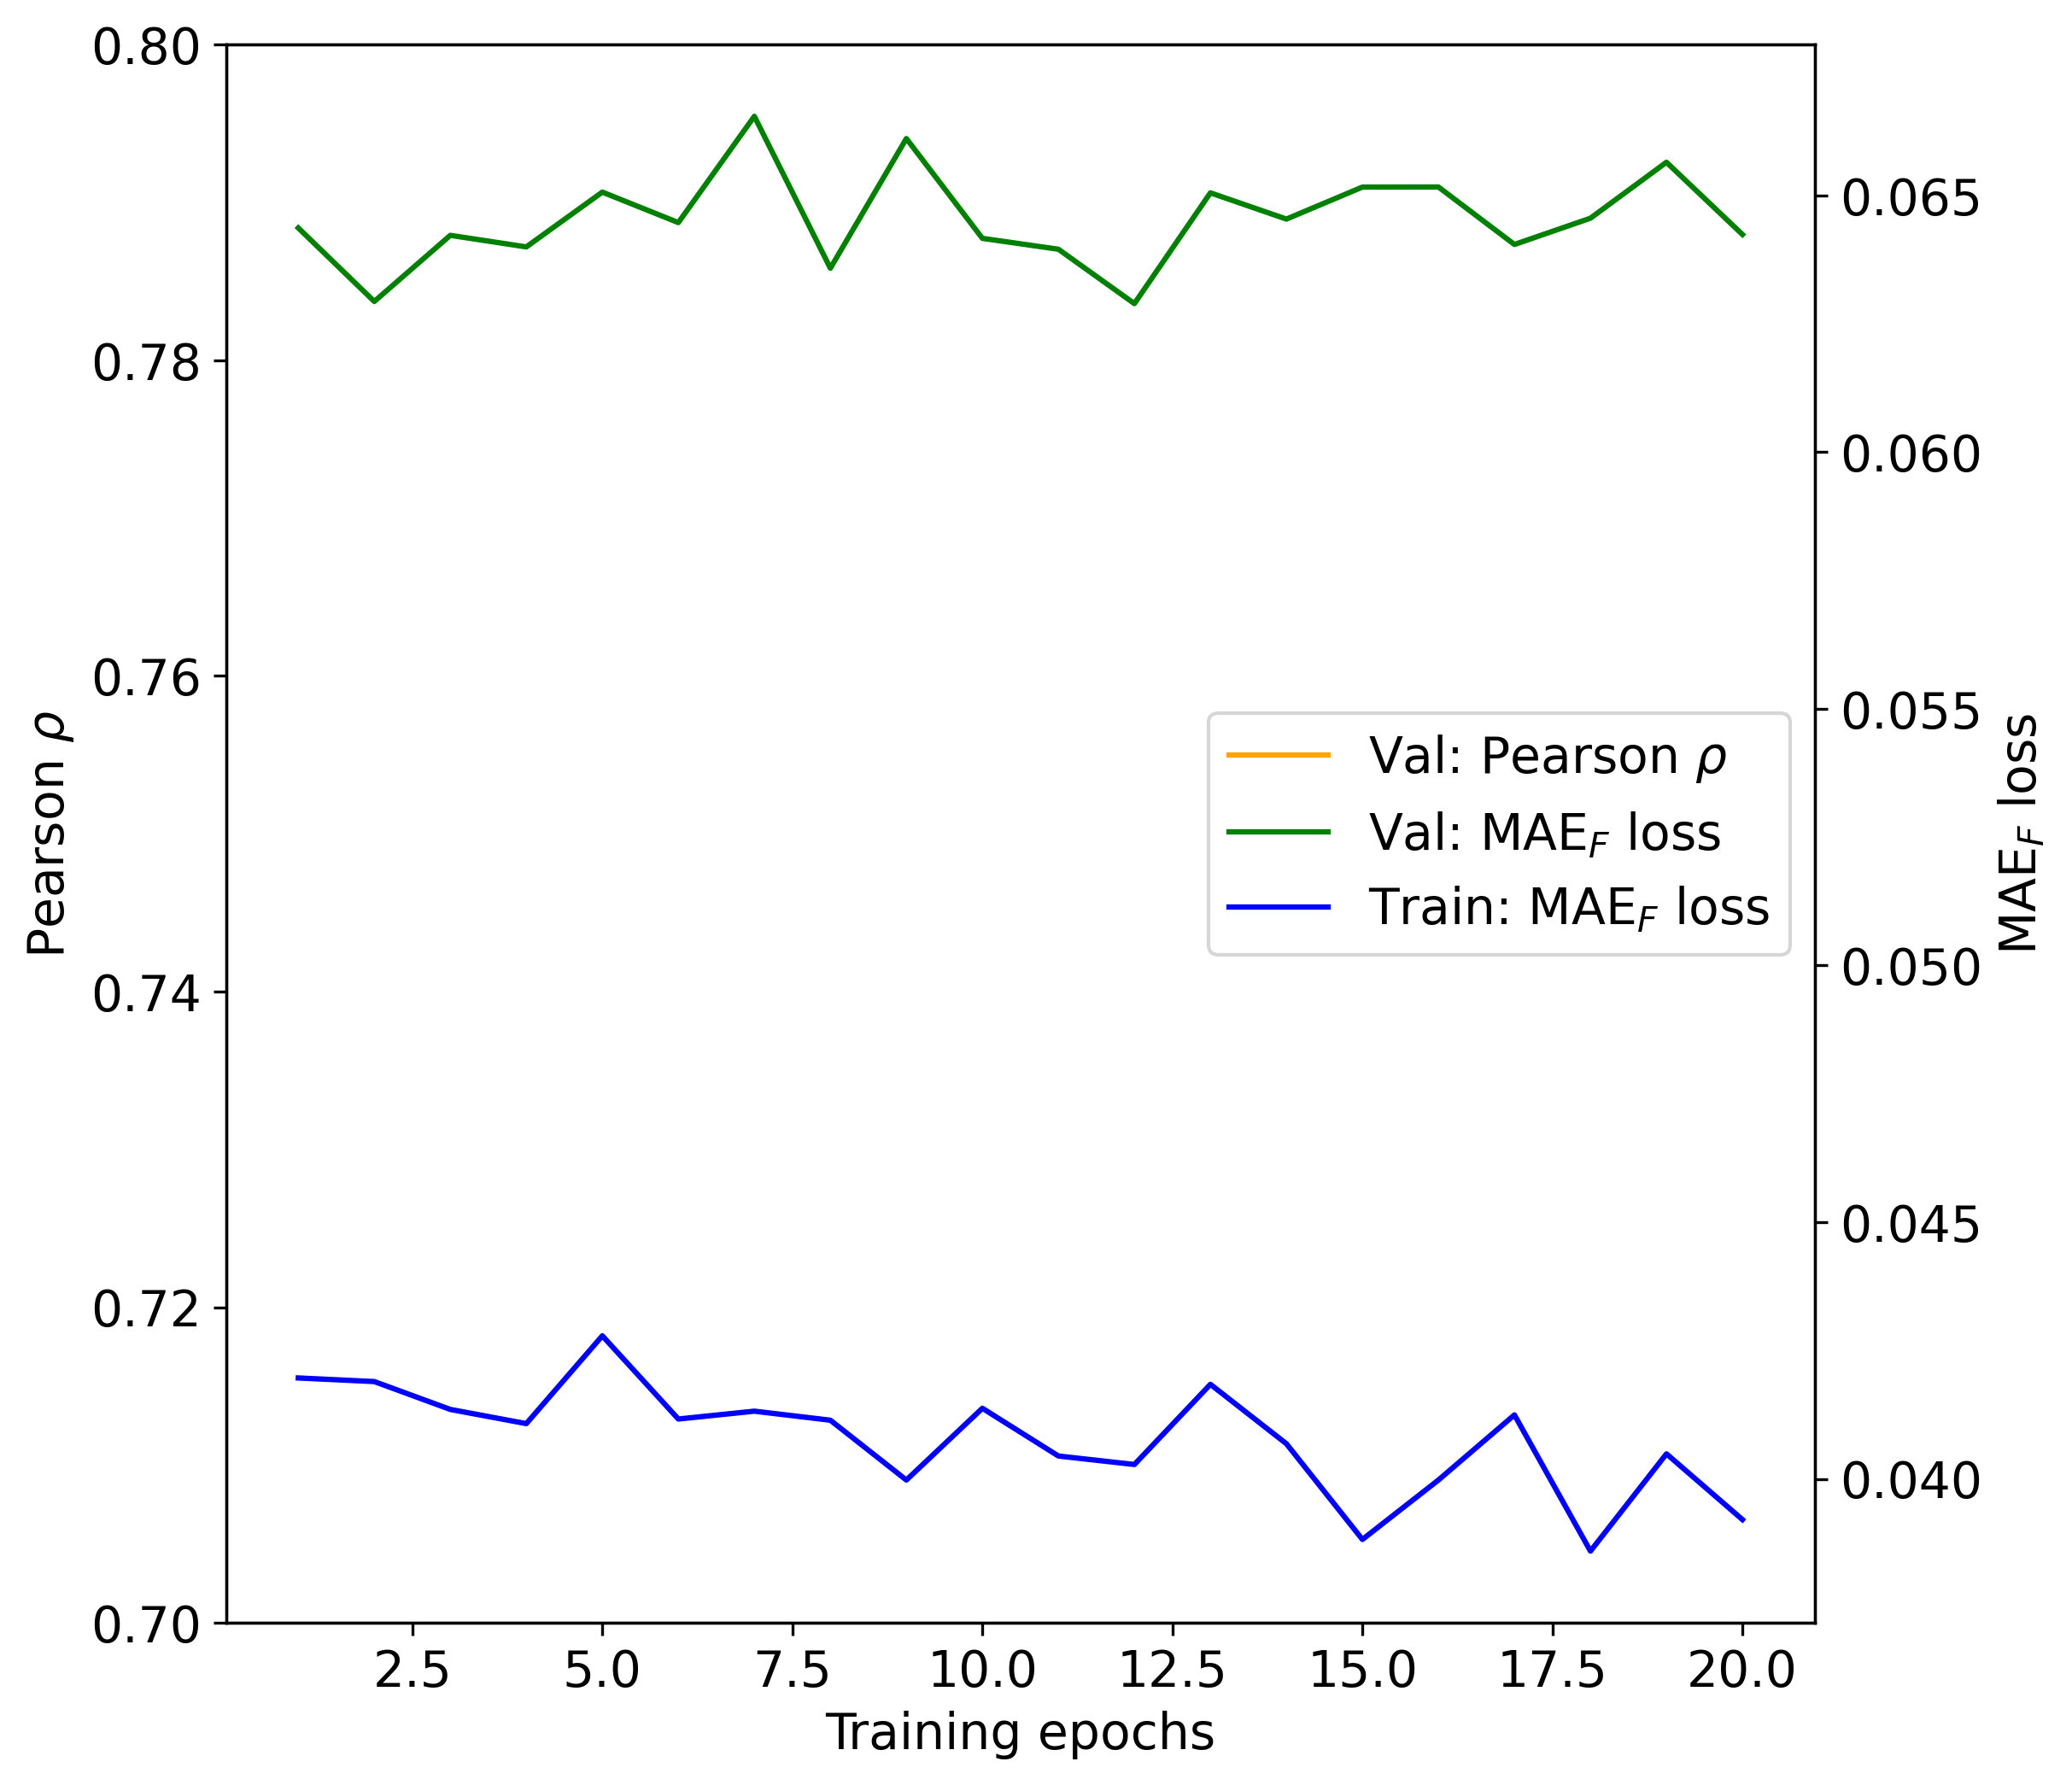

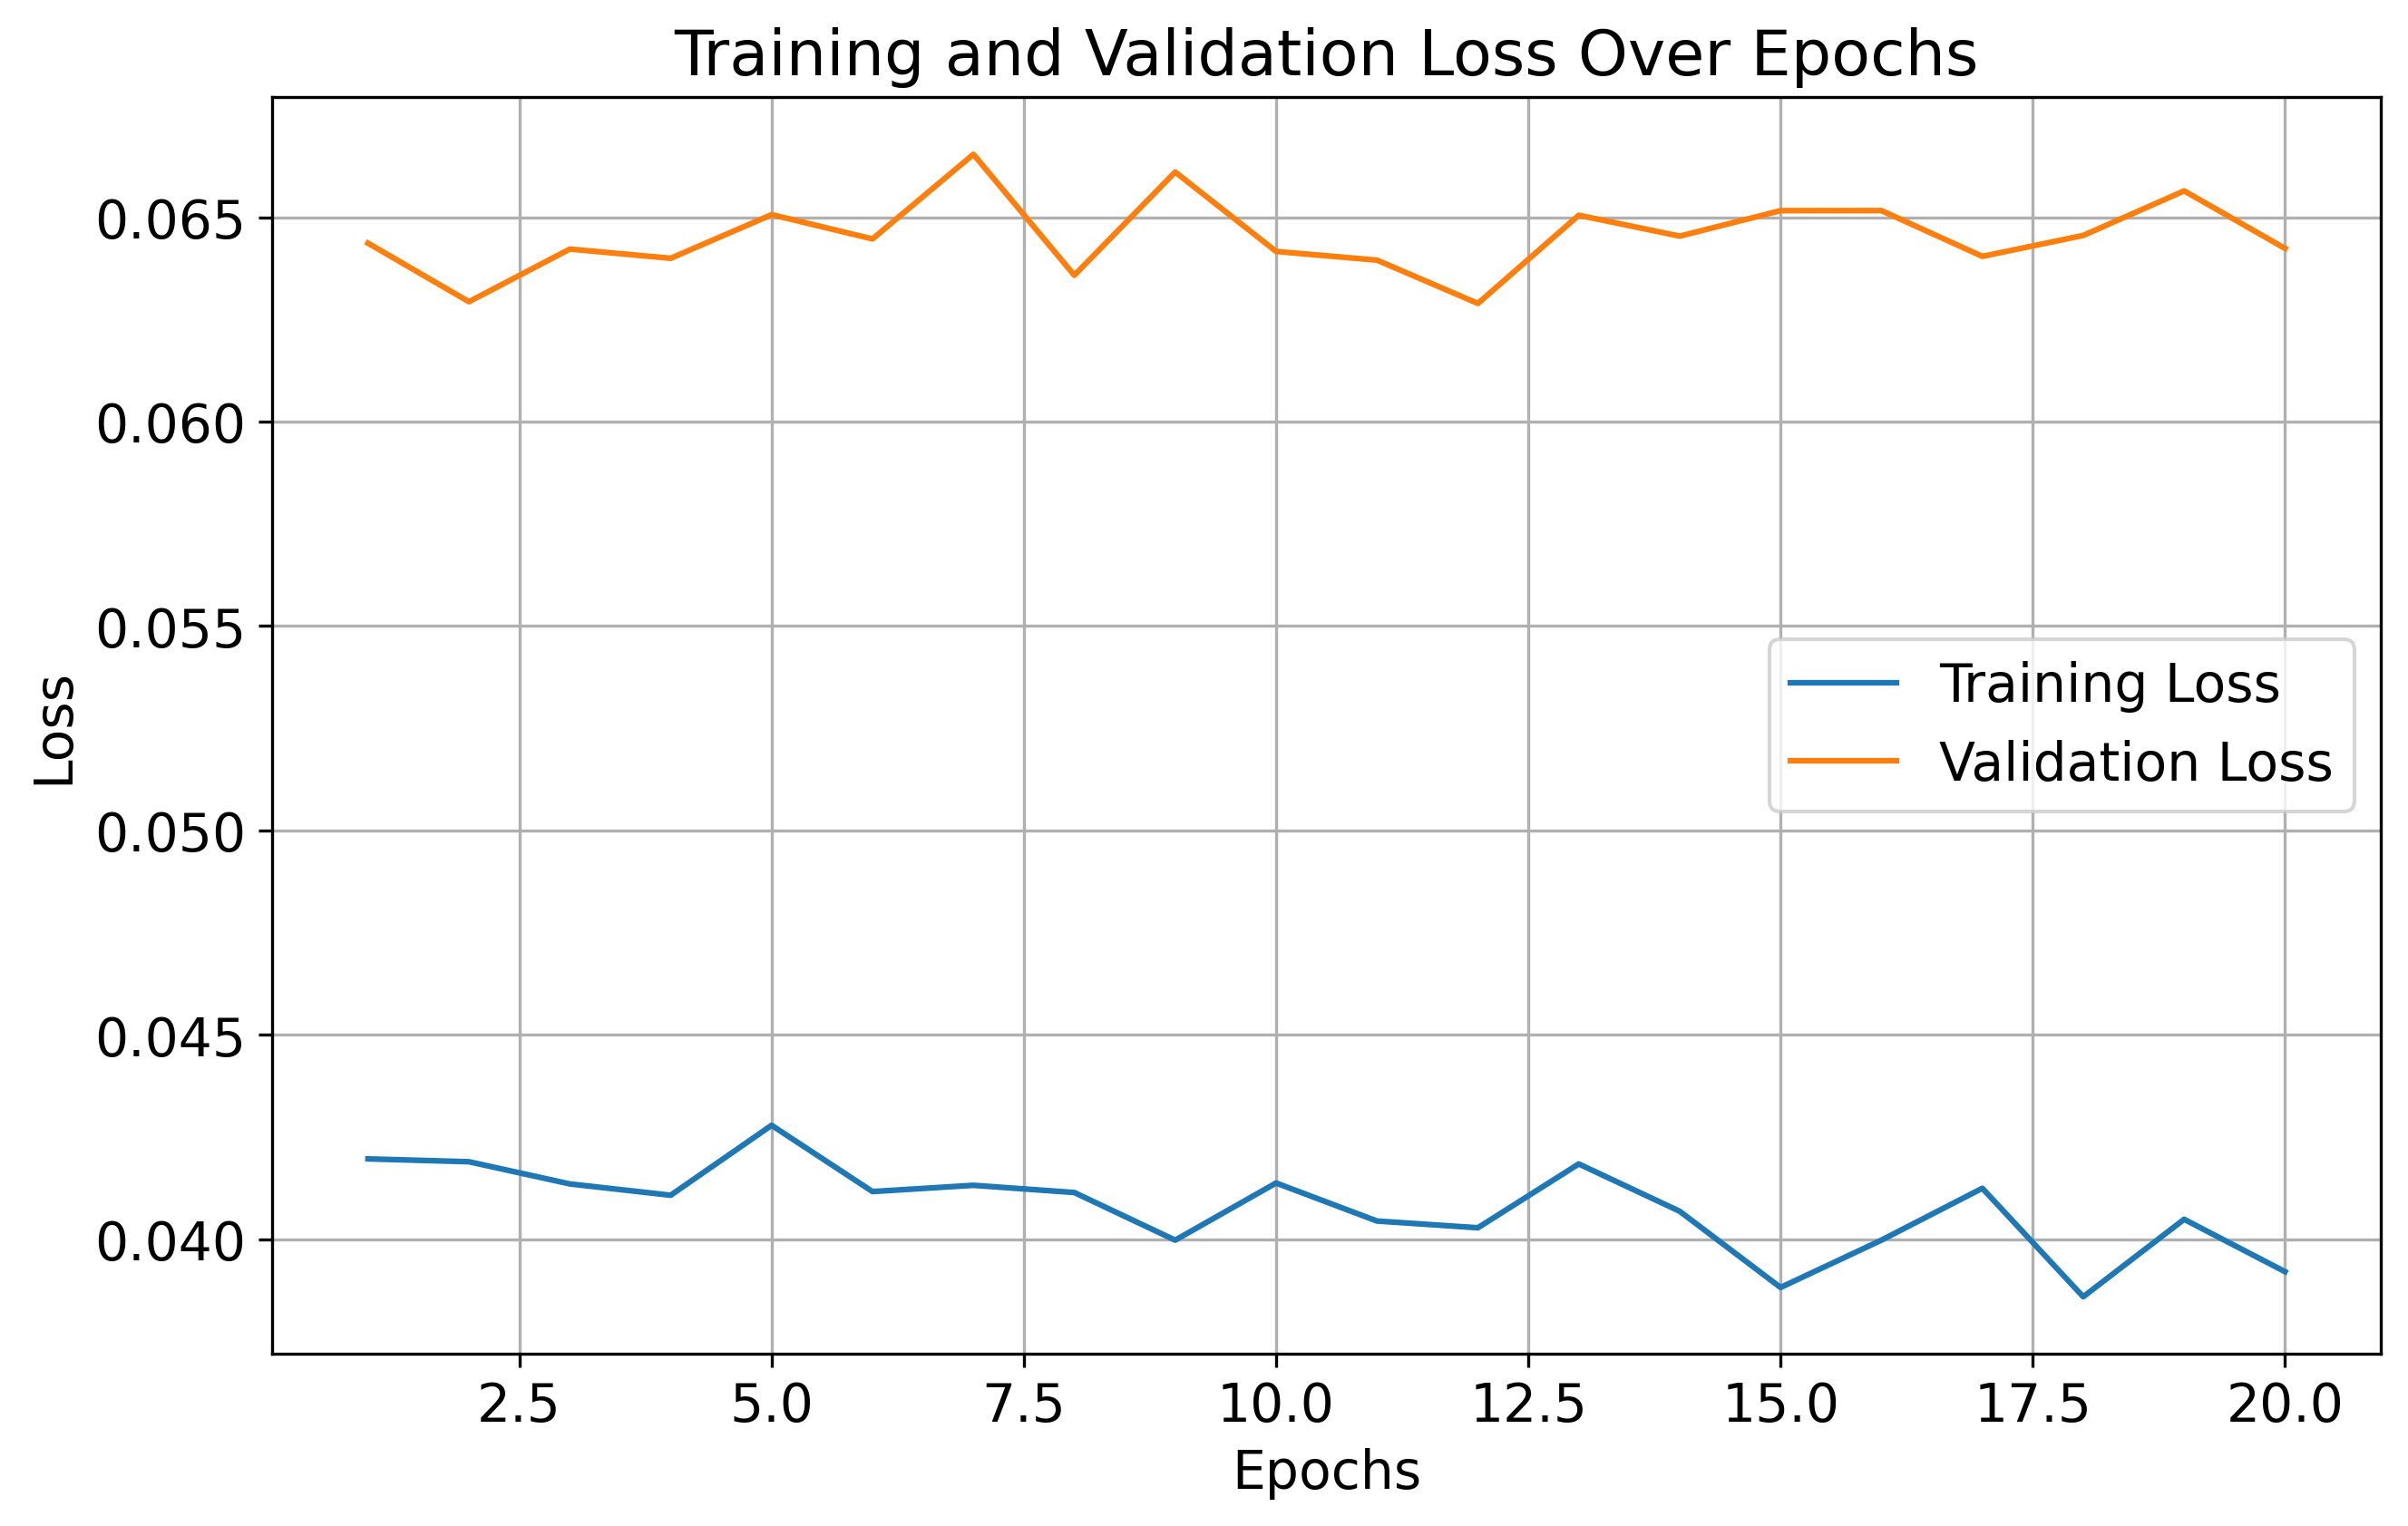

Finished training model: 1/3
Training model: 2/3
Epoch: 1/20
Epoch: 2/20
Epoch: 3/20
Epoch: 4/20
Epoch: 5/20
Epoch: 6/20
Epoch: 7/20
Epoch: 8/20
Epoch: 9/20
Epoch: 10/20
Epoch: 11/20
Epoch: 12/20
Epoch: 13/20
Epoch: 14/20
Epoch: 15/20
Epoch: 16/20
Epoch: 17/20
Epoch: 18/20
Epoch: 19/20
Epoch: 20/20


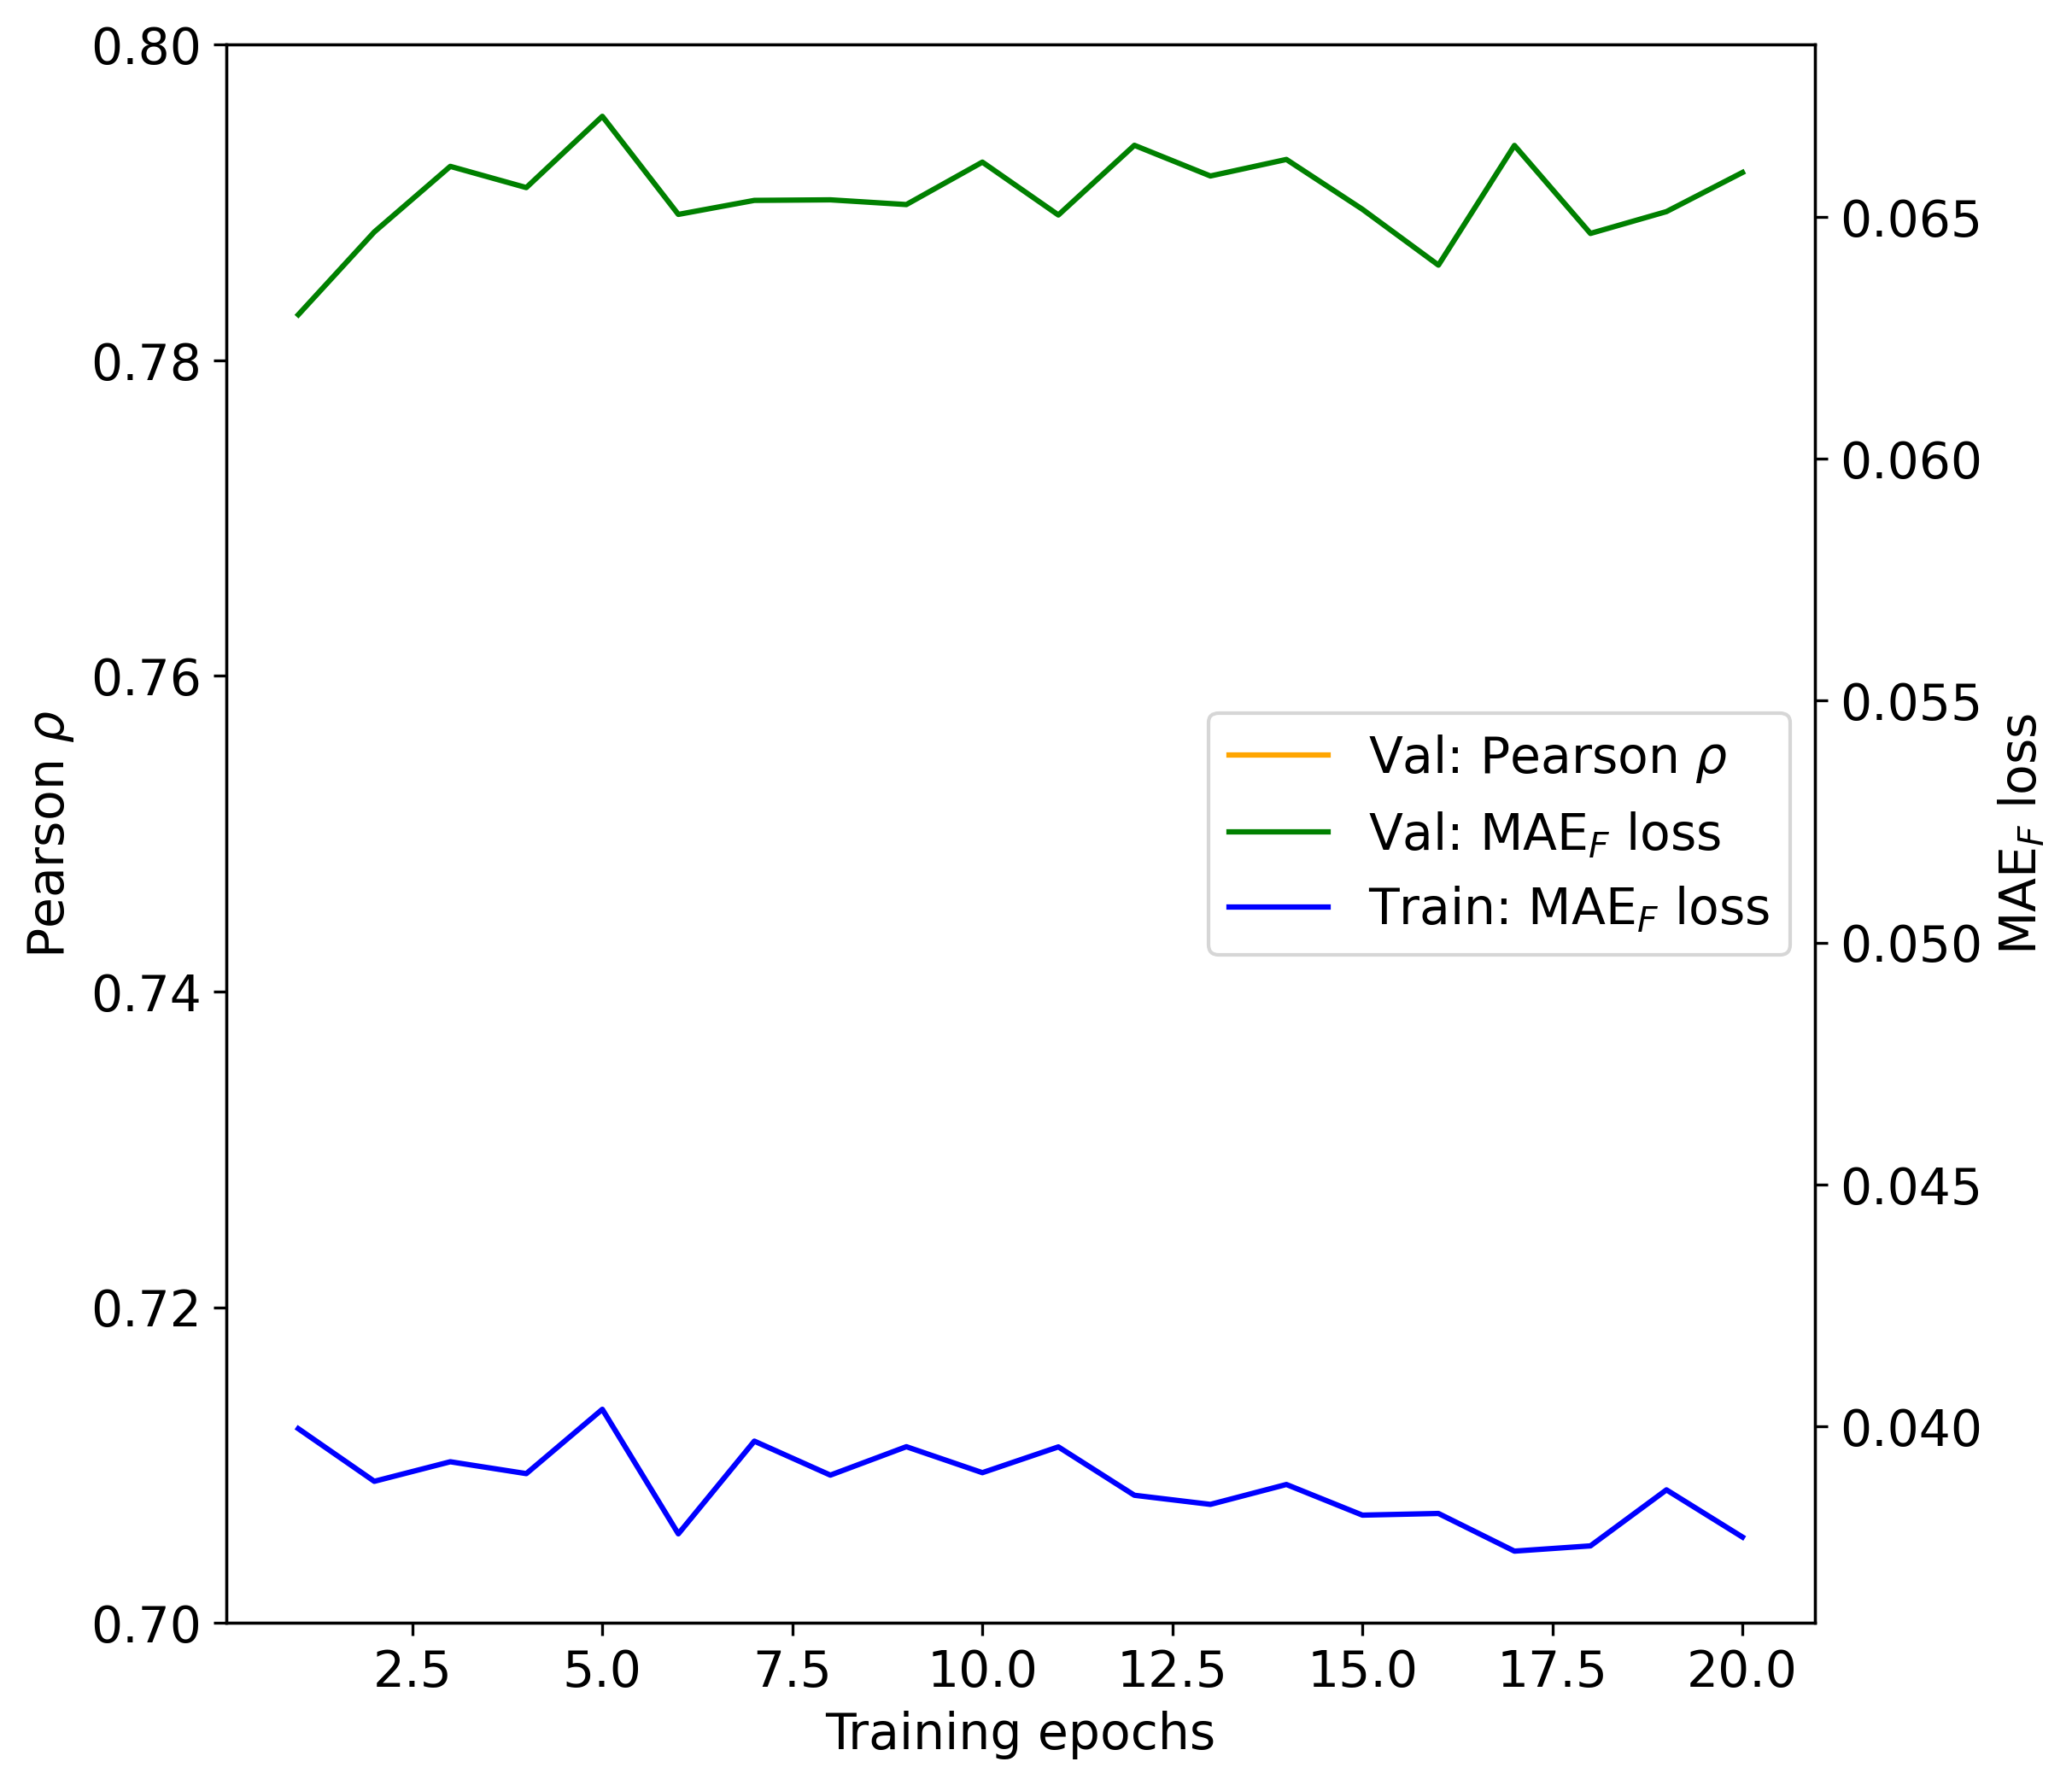

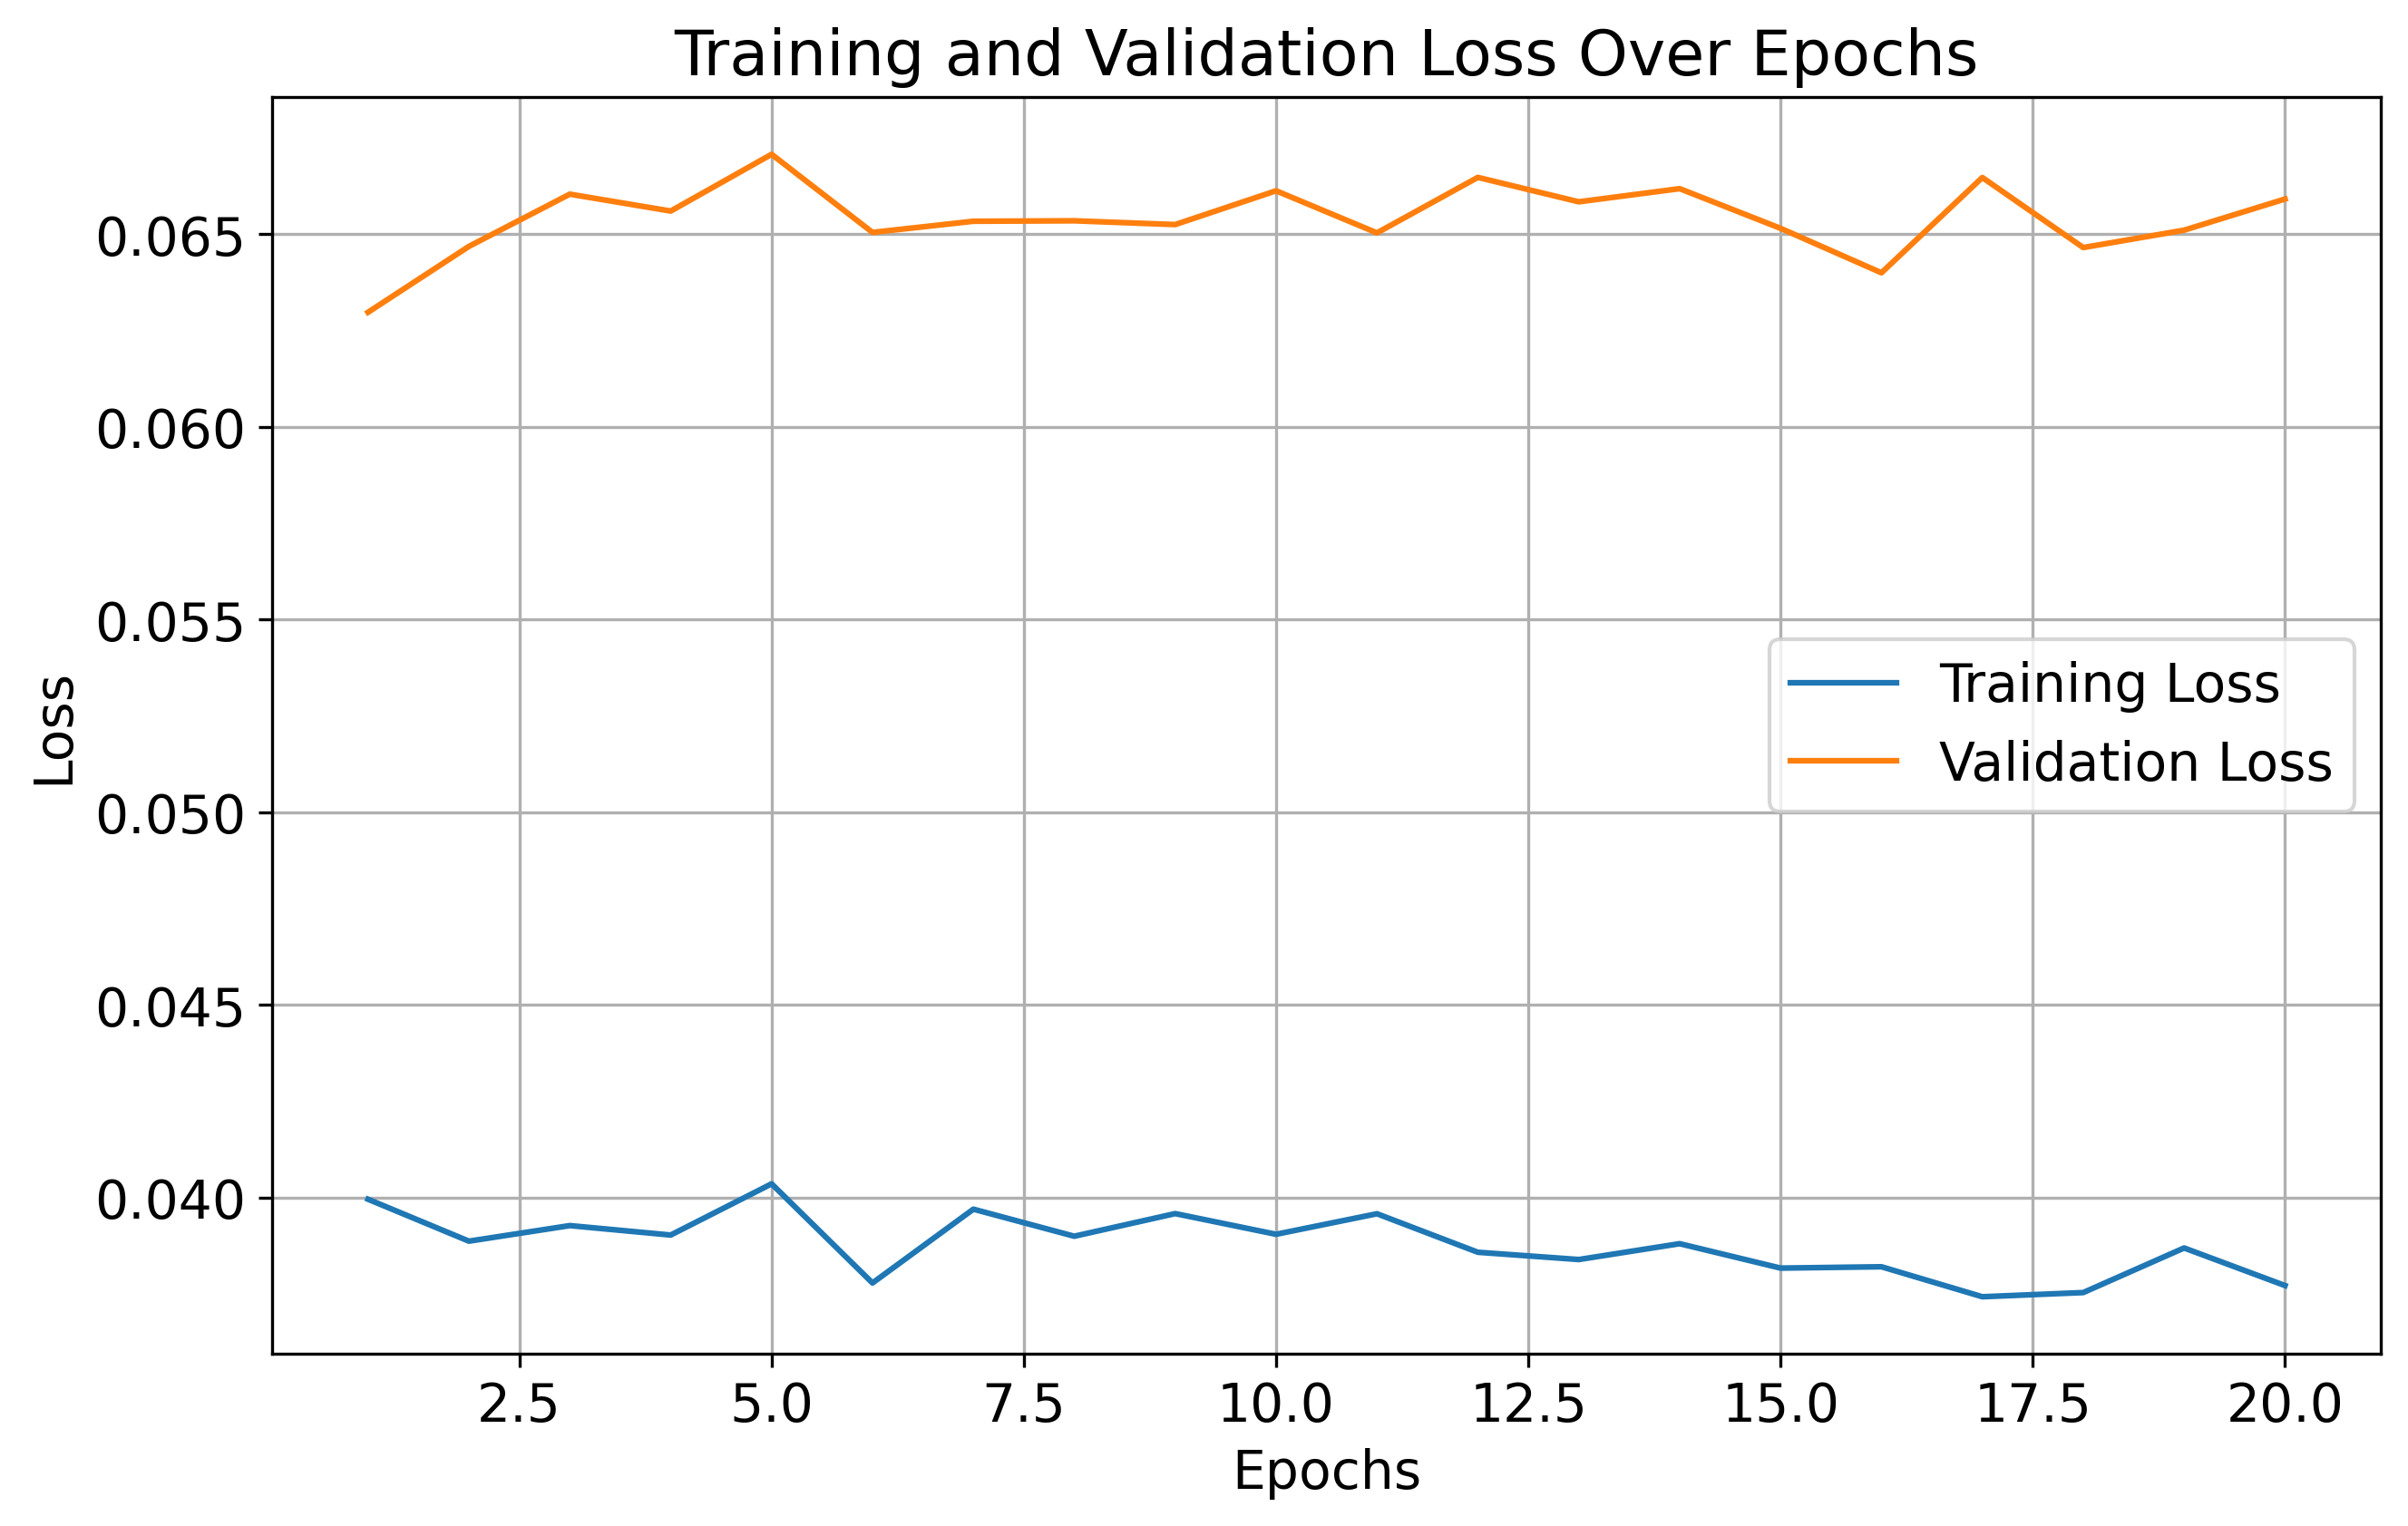

Finished training model: 2/3
Training model: 3/3
Epoch: 1/20
Epoch: 2/20
Epoch: 3/20
Epoch: 4/20
Epoch: 5/20
Epoch: 6/20
Epoch: 7/20
Epoch: 8/20
Epoch: 9/20
Epoch: 10/20
Epoch: 11/20
Epoch: 12/20
Epoch: 13/20
Epoch: 14/20
Epoch: 15/20
Epoch: 16/20
Epoch: 17/20
Epoch: 18/20
Epoch: 19/20
Epoch: 20/20


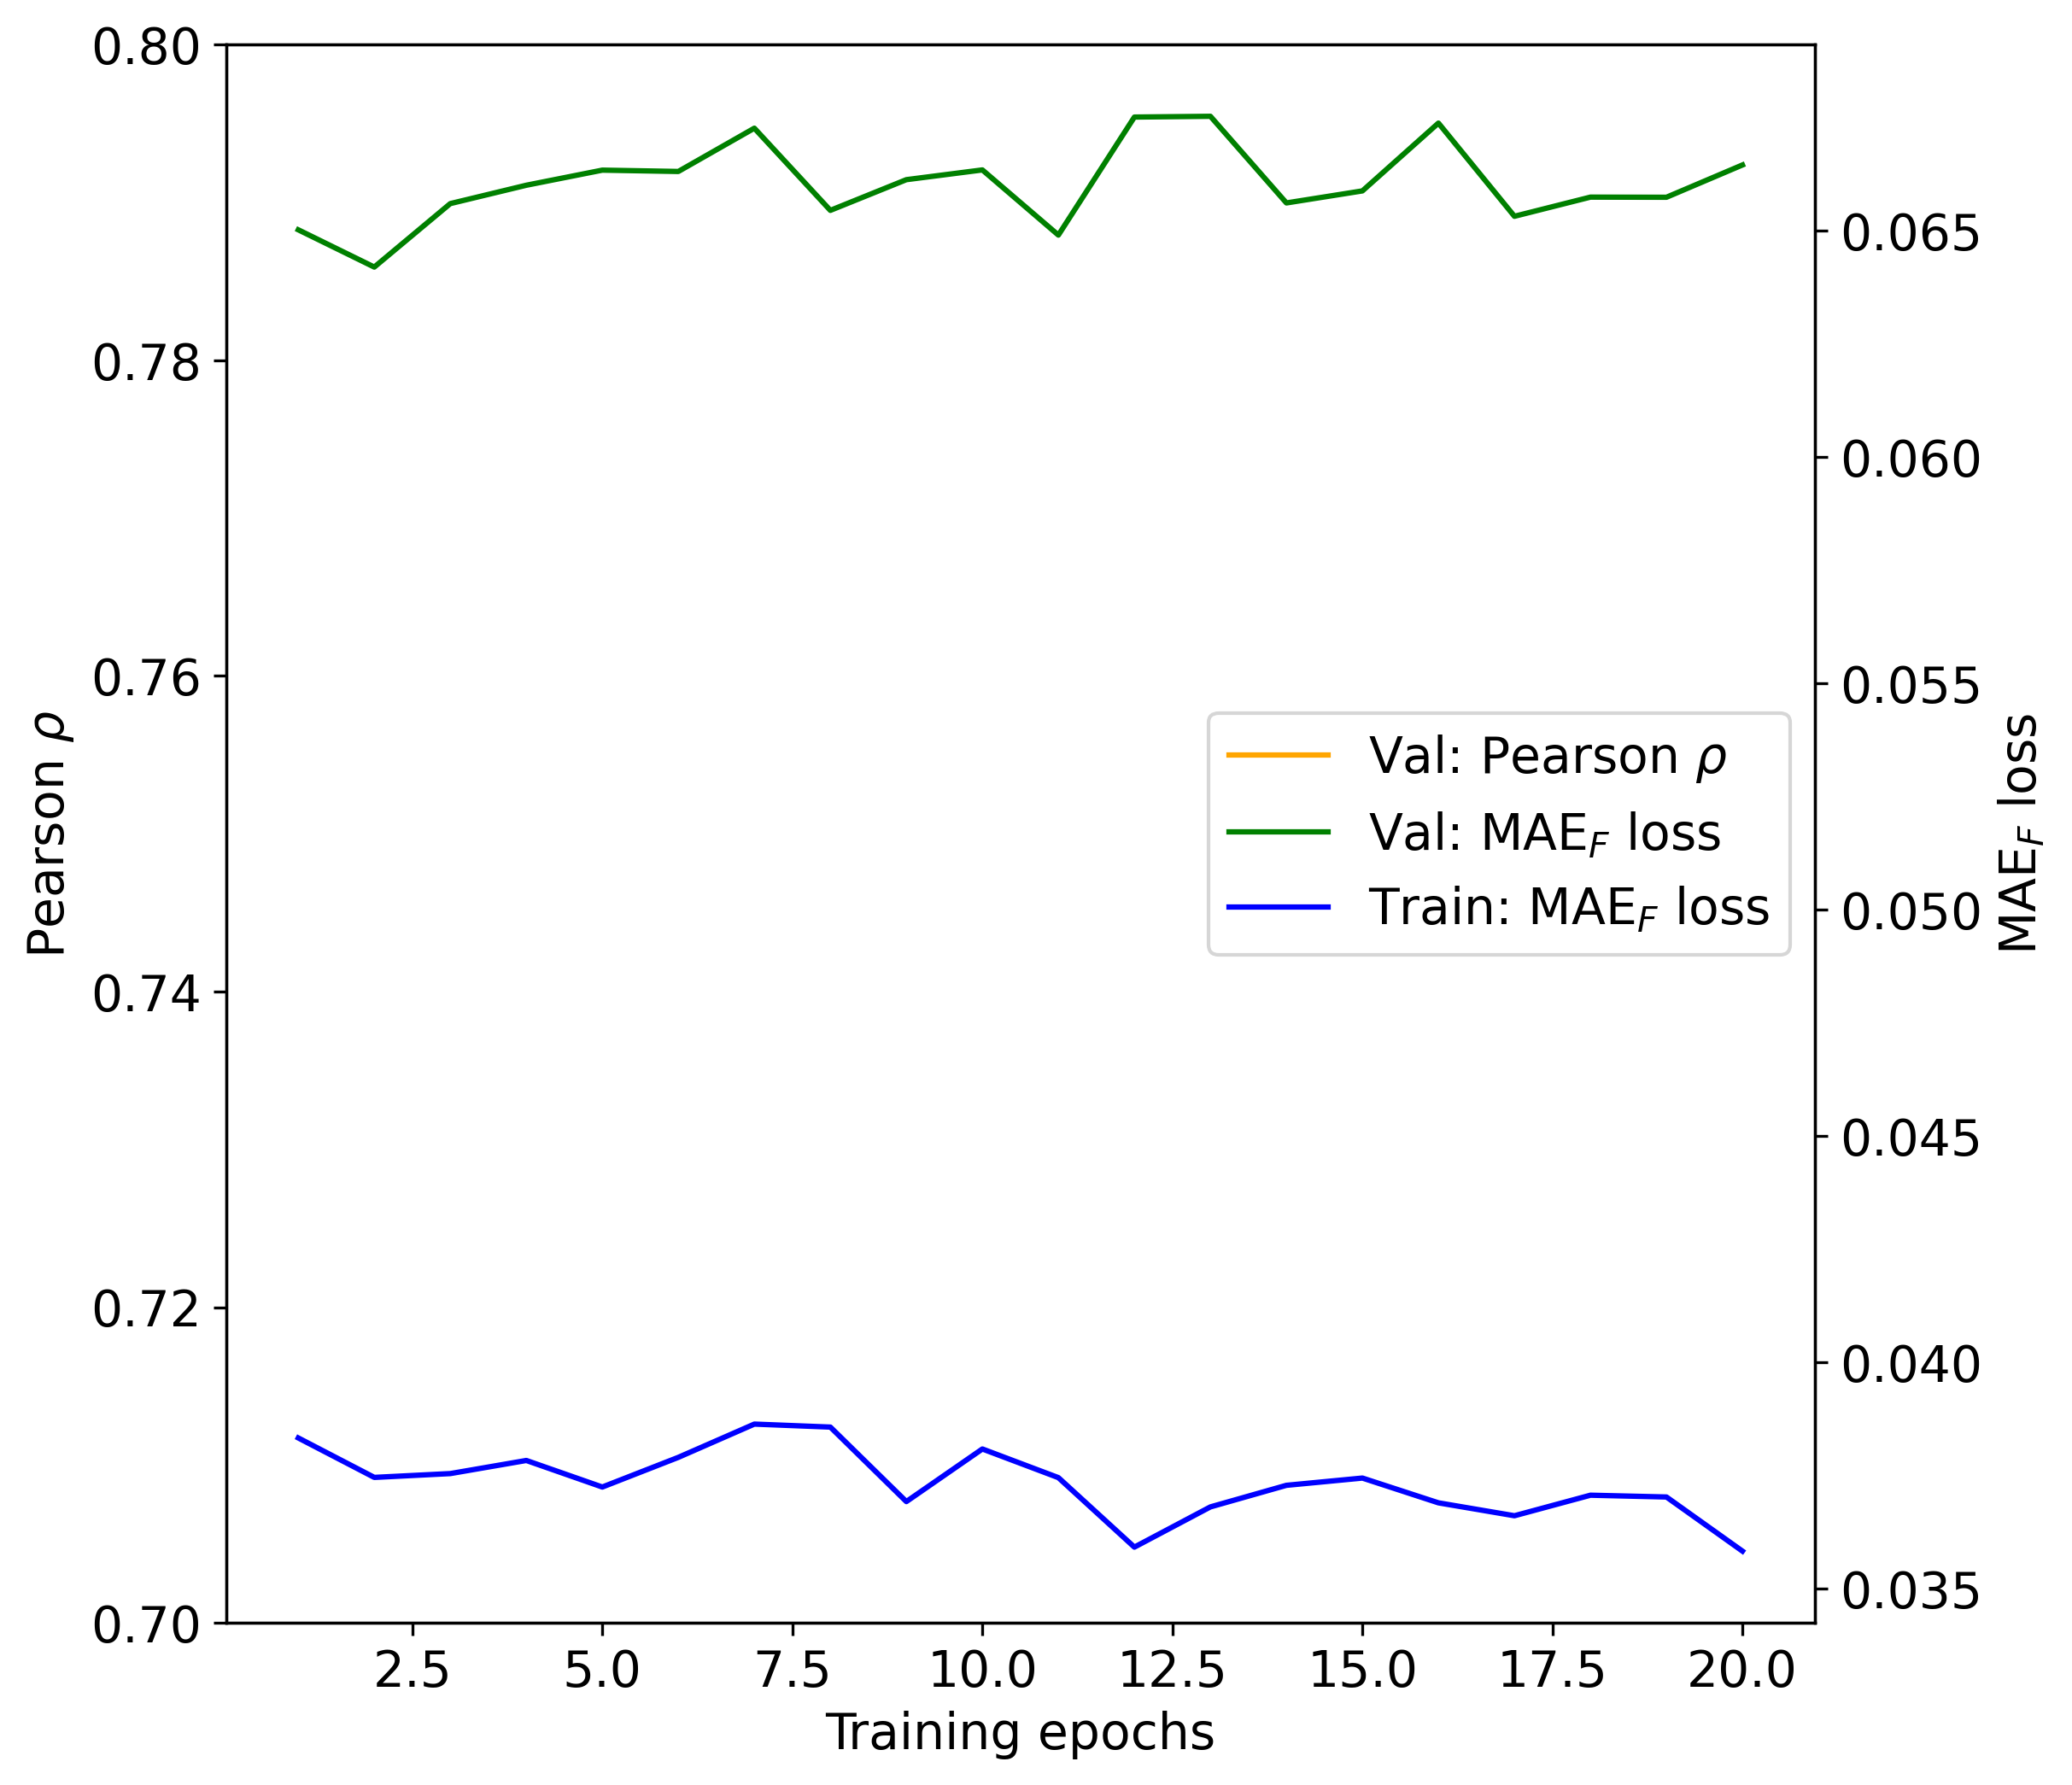

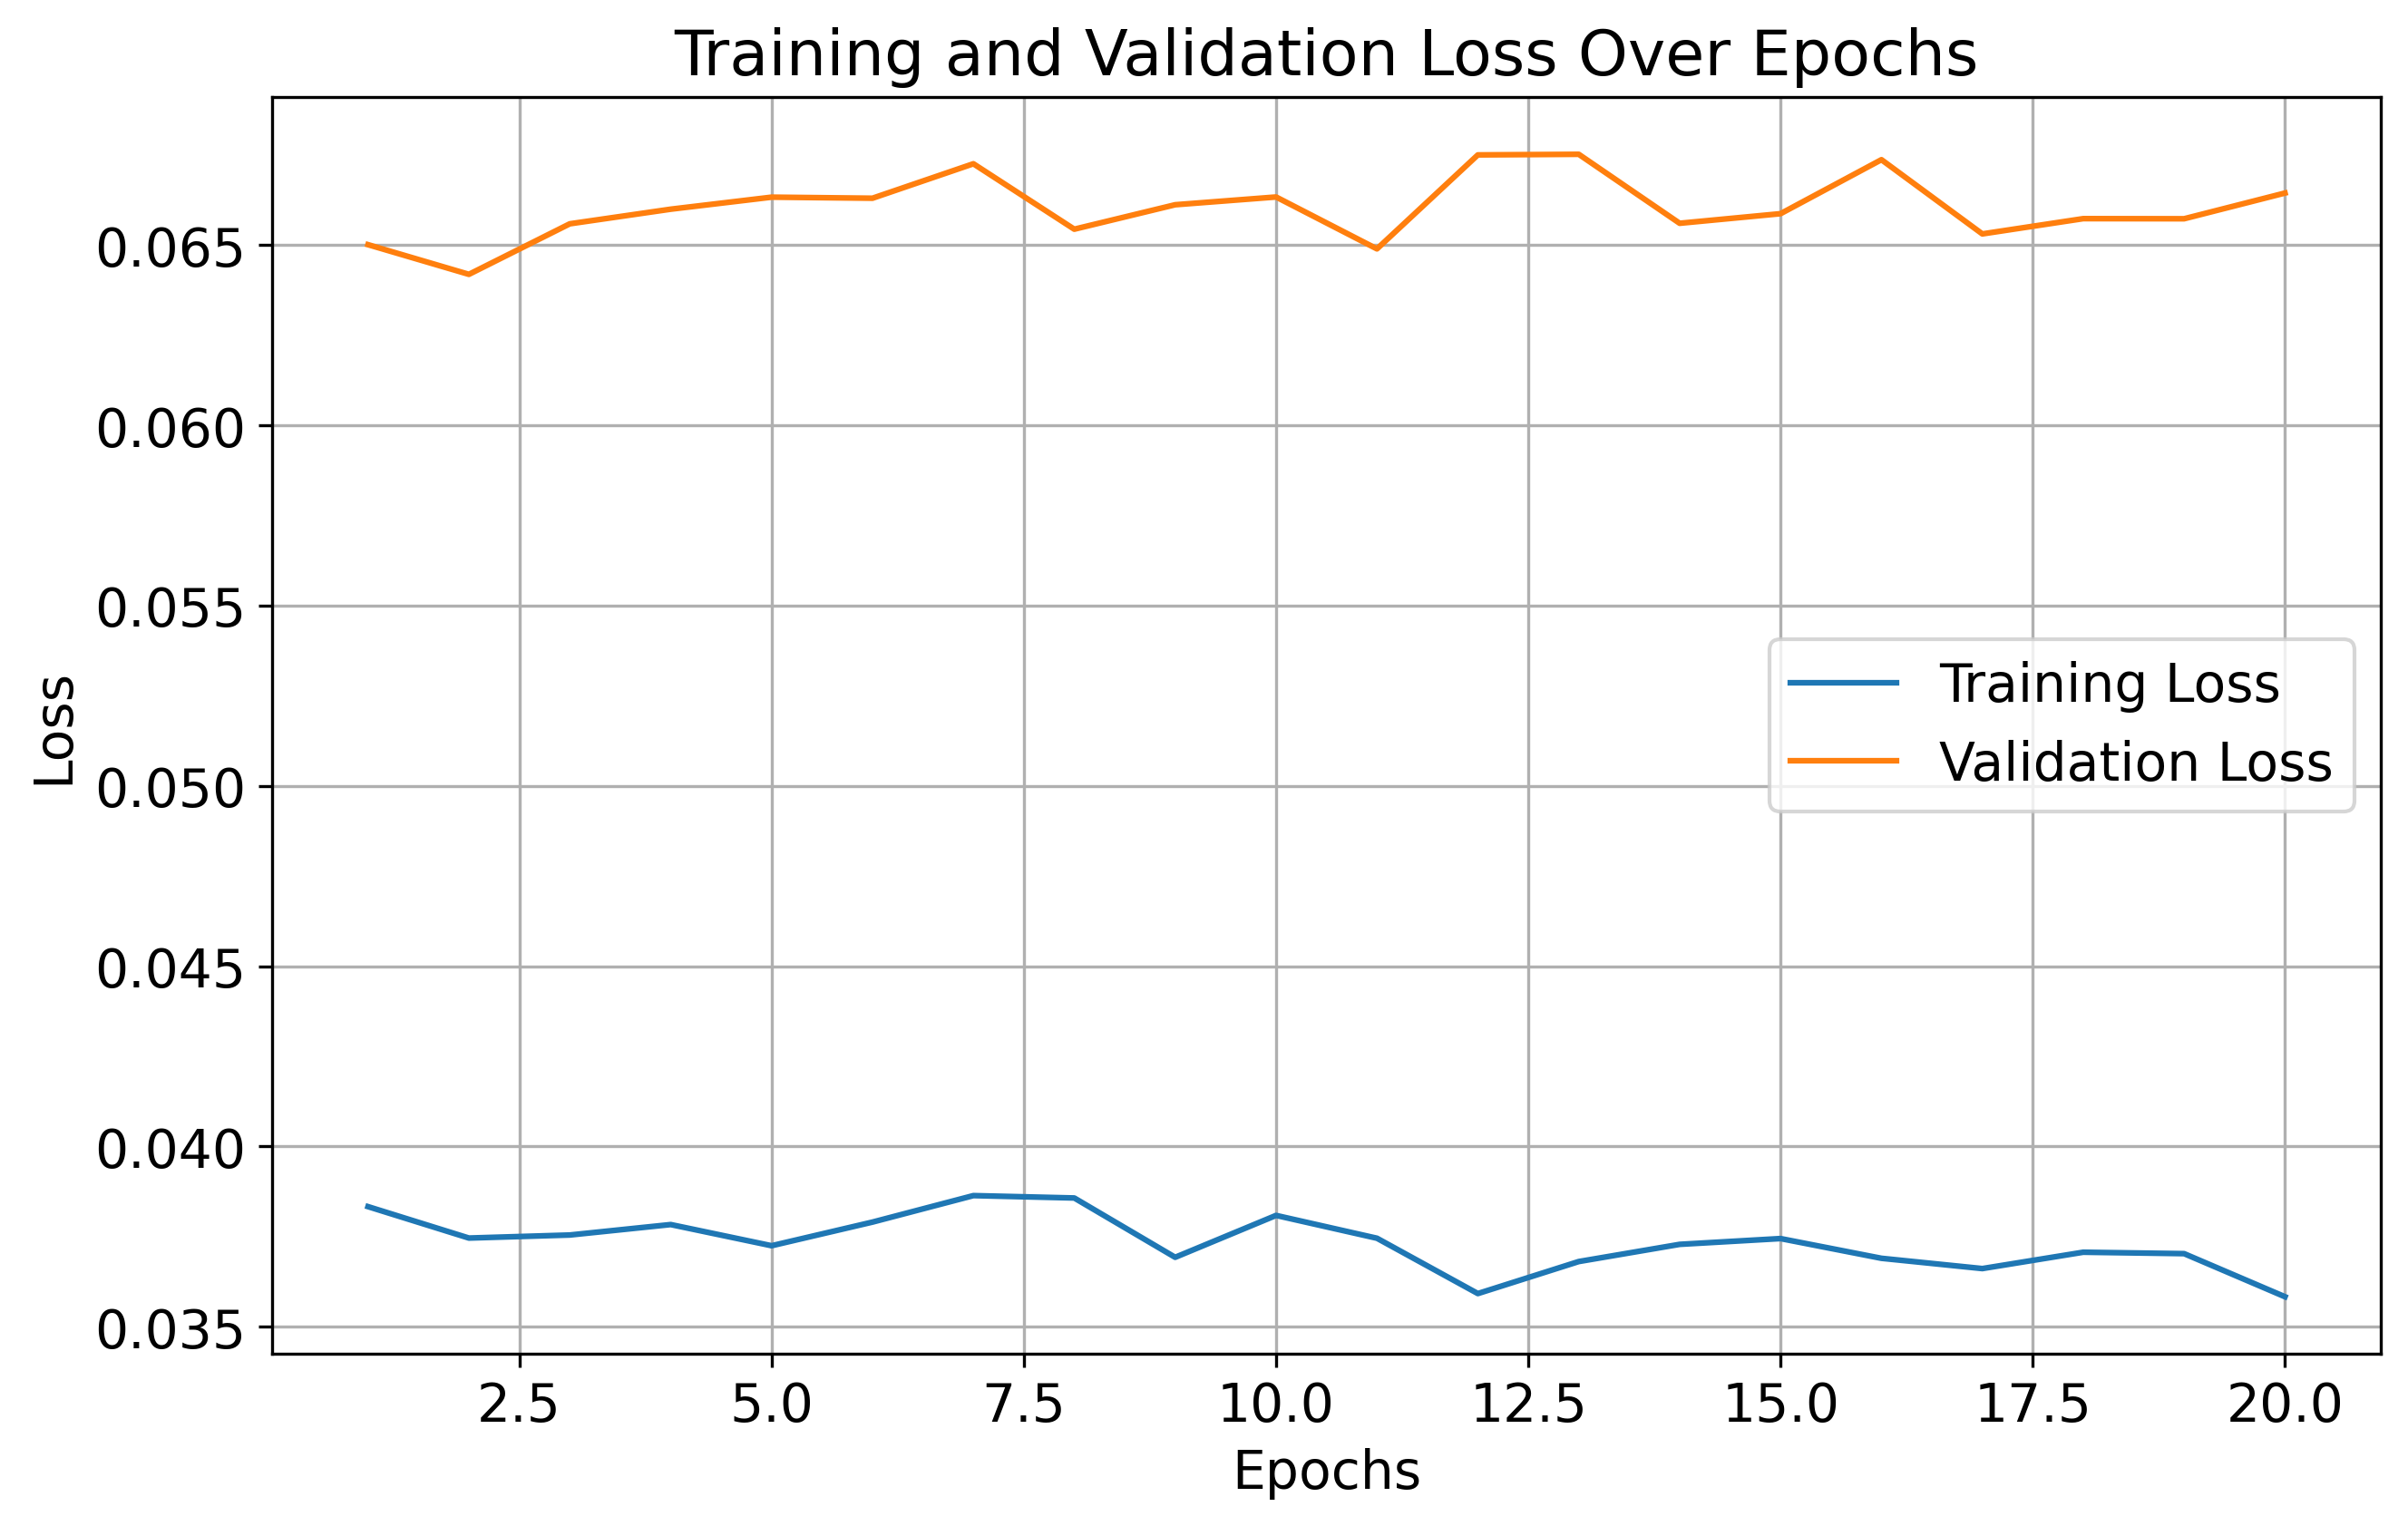

Finished training model: 3/3


In [ ]:
for model_idx in range(NUM_ENSEMBLE):
  print(f"Training model: {model_idx+1}/{NUM_ENSEMBLE}")
  ds_train_val(
              tmp_ddg,
              dataloader_train_ds,
              dataloader_val_ds,
              cavity_model_net,
              ds_model_net,
              loss_ds,
              optimizer_ds,
              model_idx,
              EPOCHS_DS,
              DEVICE,
          )
  print(f"Finished training model: {model_idx+1}/{NUM_ENSEMBLE}")

In [ ]:
df_structure_no_mt.head()


,index,resenv,pdbid,chainid,variant
0,--P68871--A--1--M--,<ResidueEnvironment with 136 atoms. pdb_id: qu...,P68871,A,M1X
1,--P68871--A--2--V--,<ResidueEnvironment with 200 atoms. pdb_id: qu...,P68871,A,V2X
2,--P68871--A--3--H--,<ResidueEnvironment with 153 atoms. pdb_id: qu...,P68871,A,H3X
3,--P68871--A--4--L--,<ResidueEnvironment with 196 atoms. pdb_id: qu...,P68871,A,L4X
4,--P68871--A--5--T--,<ResidueEnvironment with 132 atoms. pdb_id: qu...,P68871,A,T5X


In [ ]:
df_structure.head()

,resenv,pdbid,chainid,variant,wt_idx,mt_idx,wt_nlf,mt_nlf
0,<ResidueEnvironment with 136 atoms. pdb_id: qu...,P68871,A,M1A,10,0,3.785957,2.483982
1,<ResidueEnvironment with 136 atoms. pdb_id: qu...,P68871,A,M1C,10,1,3.785957,4.335140
2,<ResidueEnvironment with 136 atoms. pdb_id: qu...,P68871,A,M1D,10,2,3.785957,2.824680
3,<ResidueEnvironment with 136 atoms. pdb_id: qu...,P68871,A,M1E,10,3,3.785957,2.712832
4,<ResidueEnvironment with 136 atoms. pdb_id: qu...,P68871,A,M1F,10,4,3.785957,3.207937


In [ ]:
#@title <b><font color='#56b4e9'> Download results as archive </font></b>

#@markdown Run the cell to <b><font color='#009e74'> download a .zip archive </font></b> with prediction files for the <ins>current run</ins>.

#@markdown <ins>Tick</ins> the next box if you ran multiple predictions and you want to <ins>download all of them</ins>.

download_all_predictions= False #@param {type:"boolean"}

if download_all_predictions:
  os.system( "zip -r {} {}".format( f"predictions_output_all.zip" , f"/content/output/predictions/*" ) )
  files.download(f"predictions_output_all.zip")
else:
  if (AF_ID !=''):
    os.system( "zip -r {} {}".format( f"predictions_output_{AF_ID}.zip" , f"/content/output/predictions/*{AF_ID}*" ) )
    files.download(f"predictions_output_{AF_ID}.zip")
  elif (PDB_ID !=''):
    os.system( "zip -r {} {}".format( f"predictions_output_{PDB_ID}.zip" , f"/content/output/predictions/*{PDB_ID}*" ) )
    files.download(f"predictions_output_{PDB_ID}.zip")
  else:
    os.system( "zip -r {} {}".format( f"predictions_output.zip" , f"/content/output/predictions" ) )
    files.download(f"predictions_output.zip")

  if download_all_predictions:
    os.system( "zip -r {} {}".format( f"predictions_output.zip" , f"/content/output/predictions" ) )
    files.download(f"predictions_output_all.zip")

#@markdown **P.S.: prediction files are also stored in the colab file system folder: `/output/predictions/`**
#@markdown ****

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**CHANGING LOG**

- 12th April 2023: AlphaFold2 database version update to v4.
- 3rd April 2023: Torch version and packagess updated for python 3.9



**Troubleshooting**

- Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
- Try to restart the session "Runtime" -> "Factory reset runtime".
- Run the PRELIMINARY OPERATION one at the time, to avoid crashes.
- Check your input pdb.

\\

**Known problems:**

- Condacolab need to restart the notebook kernel, so preliminart cells MUST be run one at the time to allow this.
- Residues with numeration index below 0 are not supported by the output file parser and thus they deleted from the pdb in the pre-processing step.
- Insertion annotations in the pdb are not supported. Any annotations is actually deleted during the pre-processing step.

\\

**License:**

RaSP's source code is licensed under the permissive Apache Licence, Version 2.0.
 Additionally, this notebook uses the reduce source code which license could be find in `/content/src/pdb_parser_scripts/reduce/`

\\

**Bugs:**

For any bugs please report the issue on the project [Github](https://github.com/KULL-Centre/_2022_ML-ddG-Blaabjerg) or contact one of the listed authors in the connected [manuscript](https://www.biorxiv.org/content/10.1101/2022.07.14.500157v1).

\\

**Citing this work:**

If you use our model please cite:

Blaabjerg, L.M., Kassem, M.M., Good, L.L., Jonsson, N., Cagiada, M., Johansson, K.E., Boomsma, W., Stein, A. and Lindorff-Larsen, K., 2022. *Rapid protein stability prediction using deep learning representations*, bioRxiv. (https://doi.org/10.1101/2022.07.14.500157)



```
@article{blaabjerg2022rapid,
  title={Rapid protein stability prediction using deep learning representations},
  author={Blaabjerg, Lasse M and Kassem, Maher M and Good, Lydia L and Jonsson, Nicolas and Cagiada, Matteo and Johansson, Kristoffer E and Boomsma, Wouter and Stein, Amelie and Lindorff-Larsen, Kresten},
  journal={bioRxiv},
  year={2022},
  publisher={Cold Spring Harbor Laboratory}
}
```

